## Import Libraries

In [1]:
!pip install scikit-learn==1.5.2
!pip install dalex

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 26.8 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 9.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for dalex: filename=dalex-1.7.1-py3-none-any.whl size=1042797 sha256=2e32d039d670a26e2770730047d4e09fd7bae4bf040e8564de2b21fe2a794d20
  Stored in directory: /root/.cache/pip/wheels/50/24/3e/5a88876cfa3bd019ba82ec57c228eae1a37f479c0f8353e5cb
Successfully built dalex


In [2]:
# Import base libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Multicollinearity check
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.tools.tools import add_constant

# Image Display
from IPython.display import display, SVG
from PIL import Image
from io import BytesIO

# API
import requests
import json
import urllib
import concurrent.futures

# Distance
from geopy.distance import geodesic

# Encoding
from sklearn.preprocessing import OneHotEncoder

# Scaling
from sklearn.preprocessing import StandardScaler

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# Model Evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

# Explain complex model
import dalex as dx

In [3]:
# Display all columns
pd.set_option('display.max_columns', None)

## Objectives / Goals
- Membantu calon pembeli, penjual, dan agen properti dalam memprediksi harga jual unit HDB yang wajar berdasarkan fitur seperti lokasi, luas lantai, dan sisa sewa.
- Membantu calon pembeli maupun pemerintah untuk mengidentifikasi fitur-fitur apa saja yang mempengaruhi harga jual flat beserta besarnya pengaruh dari setiap fitur tersebut terhadap harga jual.

## Data Loading

In [4]:
# Load dataset 2015-2016 and 2017-2020
df_2015_to_2016 = pd.read_csv('https://raw.githubusercontent.com/valdo28/dataset/refs/heads/main/resale_flat_prices/resale-flat-prices-based-on-registration-date-from-jan-2015-to-dec-2016.csv')
df_2017_to_2020 = pd.read_csv('https://raw.githubusercontent.com/valdo28/dataset/refs/heads/main/resale_flat_prices/resale-flat-prices-based-on-registration-date-from-jan-2017-onwards.csv')

In [5]:
# Concatenate two datasets to create dataset 2015-2020
df = pd.concat([df_2015_to_2016, df_2017_to_2020])
df

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2015-01,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,07 TO 09,60.0,Improved,1986,70,255000.0
1,2015-01,ANG MO KIO,3 ROOM,541,ANG MO KIO AVE 10,01 TO 03,68.0,New Generation,1981,65,275000.0
2,2015-01,ANG MO KIO,3 ROOM,163,ANG MO KIO AVE 4,01 TO 03,69.0,New Generation,1980,64,285000.0
3,2015-01,ANG MO KIO,3 ROOM,446,ANG MO KIO AVE 10,01 TO 03,68.0,New Generation,1979,63,290000.0
4,2015-01,ANG MO KIO,3 ROOM,557,ANG MO KIO AVE 10,07 TO 09,68.0,New Generation,1980,64,290000.0
...,...,...,...,...,...,...,...,...,...,...,...
80369,2020-09,YISHUN,5 ROOM,716,YISHUN ST 71,07 TO 09,131.0,Improved,1987,66 years 03 months,440000.0
80370,2020-09,YISHUN,5 ROOM,760,YISHUN ST 72,07 TO 09,122.0,Improved,1987,65 years 06 months,458000.0
80371,2020-09,YISHUN,5 ROOM,835,YISHUN ST 81,04 TO 06,122.0,Improved,1987,66 years 04 months,490000.0
80372,2020-09,YISHUN,EXECUTIVE,791,YISHUN AVE 2,04 TO 06,146.0,Maisonette,1987,66 years 03 months,558000.0


## Data Understanding

**Dataset Information:**
1. Dataset berisi informasi tentang harga jual kembali flat HDB (Housing & Development Board) di Singapura mulai tahun 1990 hingga 2020. Pada analisis ini, akan dibatasi mulai tahun 2015 hingga 2020 saja.
2. Dataset berisi 4 file CSV, yang mencakup transaksi dari tahun 1990 - 2020. Ini mencakup fitur flat dan penjualan, seperti year of sale, location of the flat, flat type, street name, block number, area of the
flat, lease and resale price.

**Column Description:**
- `month`: month and year of transaction
- `town`: town of flat
- `flat_type`: type of flat
- `block`: block number of flat
- `street_name`: street name of flat
- `storey_range`: storey of flat
- `floor_area_sqm`: floor area of flat in square meter
- `flat_model`: model of flat
- `lease_commence_date`: date the lease started
- `remaining_lease`: the number of years, months and days left before the lease expires.
- `resale_price`: nominal resale price of flat (in Singapore Dollars, SGD)

## Data Cleaning

### Missing Value

In [6]:
# Check for missing values
missing_values = df.isna().sum().reset_index()
missing_values.columns = ['Feature', 'Missing_Values']
missing_values['Percentage'] = round((missing_values['Missing_Values']/len(df))*100, 2)
missing_values = missing_values.sort_values(by='Missing_Values', ascending=False)
missing_values

,Feature,Missing_Values,Percentage
0,month,0,0.0
1,town,0,0.0
2,flat_type,0,0.0
3,block,0,0.0
4,street_name,0,0.0
5,storey_range,0,0.0
6,floor_area_sqm,0,0.0
7,flat_model,0,0.0
8,lease_commence_date,0,0.0
9,remaining_lease,0,0.0


In [7]:
missing_rows = df.isna().any(axis=1).sum()
percentage_missing = str(round(missing_rows/len(df)*100, 2)) + '%'
print(f'Total missing values of this dataset is {missing_rows} which is {percentage_missing} of the whole data.')

Total missing values of this dataset is 0 which is 0.0% of the whole data.


**Observation:** <br>
No missing data was found, so there is no need to handle missing data.

### Duplicated Data

In [8]:
# Check duplicated data count
df.duplicated().sum()

234

**Observation:** <br>
Duplicated data was found. Drop the duplicated data.

In [9]:
# Drop the duplicated data
df = df.drop_duplicates()

# Re-check duplicated data count
df.duplicated().sum()

0

## Data Manipulation
Manipulate columns (add or remove) and manipulate data types

In [10]:
df.sample(n=10, random_state=42)

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
48162,2019-04,TOA PAYOH,3 ROOM,8,LOR 7 TOA PAYOH,07 TO 09,66.0,Improved,1970,50 years 04 months,258000.0
24078,2016-05,BUKIT MERAH,4 ROOM,76A,REDHILL RD,13 TO 15,100.0,Model A,2005,88,750000.0
52635,2019-07,BEDOK,5 ROOM,62,CHAI CHEE RD,07 TO 09,133.0,Model A,1983,63 years 03 months,543000.0
20603,2016-03,BUKIT PANJANG,3 ROOM,458,SEGAR RD,07 TO 09,68.0,Premium Apartment,2012,95,310000.0
7689,2017-05,TOA PAYOH,4 ROOM,141,LOR 2 TOA PAYOH,25 TO 27,100.0,Model A,2001,82 years 08 months,740000.0
65165,2020-01,KALLANG/WHAMPOA,3 ROOM,10,GLOUCESTER RD,01 TO 03,67.0,New Generation,1976,55 years 11 months,362000.0
805,2015-01,QUEENSTOWN,3 ROOM,98,C'WEALTH CRES,07 TO 09,68.0,Standard,1970,54,350000.0
39090,2018-11,BUKIT MERAH,4 ROOM,19,CANTONMENT CL,10 TO 12,90.0,Model A,2002,83 years 01 month,708000.0
3918,2015-04,BEDOK,4 ROOM,221C,BEDOK CTRL,07 TO 09,94.0,Model A,2010,94,630000.0
2668,2017-03,BUKIT PANJANG,4 ROOM,163,GANGSA RD,22 TO 24,102.0,Model A,1998,80 years 02 months,475000.0


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 117293 entries, 0 to 80373
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   month                117293 non-null  object 
 1   town                 117293 non-null  object 
 2   flat_type            117293 non-null  object 
 3   block                117293 non-null  object 
 4   street_name          117293 non-null  object 
 5   storey_range         117293 non-null  object 
 6   floor_area_sqm       117293 non-null  float64
 7   flat_model           117293 non-null  object 
 8   lease_commence_date  117293 non-null  int64  
 9   remaining_lease      117293 non-null  object 
 10  resale_price         117293 non-null  float64
dtypes: float64(2), int64(1), object(8)
memory usage: 10.7+ MB


In [12]:
df = df.copy()

### Extract Years

In [13]:
# Extract the years only on remaining_lease
def extract_years(remaining_lease):
  remaining_lease_str = str(remaining_lease)
  if 'years' in remaining_lease_str:
    return remaining_lease_str.split('years')[0]
  else:
    return remaining_lease_str

# Overwrite remaining_lease
df['remaining_lease'] = df['remaining_lease'].apply(extract_years)

### Change Data Type

In [14]:
# Month to datetime with Year and Month format
df['month'] = pd.to_datetime(df['month'], format='%Y-%m')

# Floor area sqm to integer
df['floor_area_sqm'] = df['floor_area_sqm'].astype(int)

# Resale price to numeric
df['resale_price'] = pd.to_numeric(df['resale_price']).astype(int)

# Remaining lease to numeric
df['remaining_lease'] = pd.to_numeric(df['remaining_lease']).astype(int)

## Pre-Split Exploratory Data Analysis (EDA)
*On whole dataset*

### Statistical Summary

In [15]:
# Grouping data
numericals = df.select_dtypes(include=['number']).columns.to_list()
categoricals = df.select_dtypes(include=['object']).columns.to_list()

In [16]:
# Numericals statistical summary
df[numericals].describe().T

,count,mean,std,min,25%,50%,75%,max
floor_area_sqm,117293.0,97.432473,24.269272,31.0,77.0,95.0,112.0,280.0
lease_commence_date,117293.0,1993.101200,12.335391,1966.0,1984.0,1993.0,2002.0,2019.0
remaining_lease,117293.0,74.130929,12.234884,45.0,65.0,73.0,83.0,97.0
resale_price,117293.0,438533.457453,148170.714216,140000.0,333000.0,408000.0,508000.0,1258000.0


**Observation:** <br>
- `floor_area_sqm`:
  - The mean floor area is 97.4 sqm, but values range widely from 31 sqm to 280 sqm.
  - Median (95 sqm) is slightly below the mean, indicating a right-skewed distribution (some large properties influence the mean).
- `lease_commence_date`:
  - The average lease commenced in 1993.
- `remaining_lease`:
  - The average remaining lease is 74 years.
- `resale_price`:
  - The average resale price is 438,533.
  - The minimum price is 140,000, while some properties exceed 1.25 million, suggesting luxury or high-demand locations.
  - The median (408,000) is lower than the mean (438,533), meaning the resale price have right-skewed distribution.

In [17]:
# Categoricals statistical summary
df[categoricals].describe().T

,count,unique,top,freq
town,117293,26,SENGKANG,9000
flat_type,117293,7,4 ROOM,48336
block,117293,2452,2,434
street_name,117293,548,YISHUN RING RD,1863
storey_range,117293,17,04 TO 06,27605
flat_model,117293,20,Model A,37356


**Observation:**
- `town`:
  - Sengkang is the most frequent town (9,000 units).
  - The dataset covers 26 different towns.
- `flat_type`:
  - 4-Room flats dominate the dataset (48,336 units, ~41%).
- `block`:
  - Block 2 has the highest resale transactions (434 units).
- `street_name`:
  - Yishun Ring Road is the most common (1,863 transactions).
- `storey_range`:
  - Most transactions are from 4th to 6th floors (27,605 units).
- `flat_model`:
  - Model A is the most common flat model (37,356 units, ~32%).
  - There are 20 different flat models, indicating there are many flat models.
- `remaining_lease`:
  - 94 years is the most common lease duration (5,683 transactions).

### Univariate Analysis

#### Town vs Resale Price

In [18]:
# Statistical summary by 'town'
df_town = df.groupby('town').describe()['resale_price']
df_town

,count,mean,min,25%,50%,75%,max,std
town,,,,,,,,
ANG MO KIO,5450.0,408549.455046,174000.0,292000.0,348000.0,475000.0,1030000.0,160734.636278
BEDOK,6784.0,408239.471403,180000.0,297467.5,368000.0,488000.0,935000.0,142102.414549
BISHAN,2214.0,629760.992322,210000.0,508000.0,608000.0,755000.0,1180000.0,176711.277420
BUKIT BATOK,4450.0,383916.627416,208000.0,280000.0,358000.0,448000.0,890000.0,122606.855882
BUKIT MERAH,4453.0,556197.244779,157000.0,360000.0,570000.0,729000.0,1200000.0,204932.664893
BUKIT PANJANG,4578.0,422622.712538,200000.0,340000.0,410000.0,480000.0,840000.0,106445.183627
BUKIT TIMAH,308.0,710937.720779,320000.0,579722.0,712500.0,871250.0,1058000.0,188579.726431
CENTRAL AREA,1064.0,639448.973684,200000.0,425000.0,549000.0,890000.0,1258000.0,251623.495434
CHOA CHU KANG,5098.0,390917.974304,200000.0,335000.0,372000.0,428000.0,900000.0,79419.939689


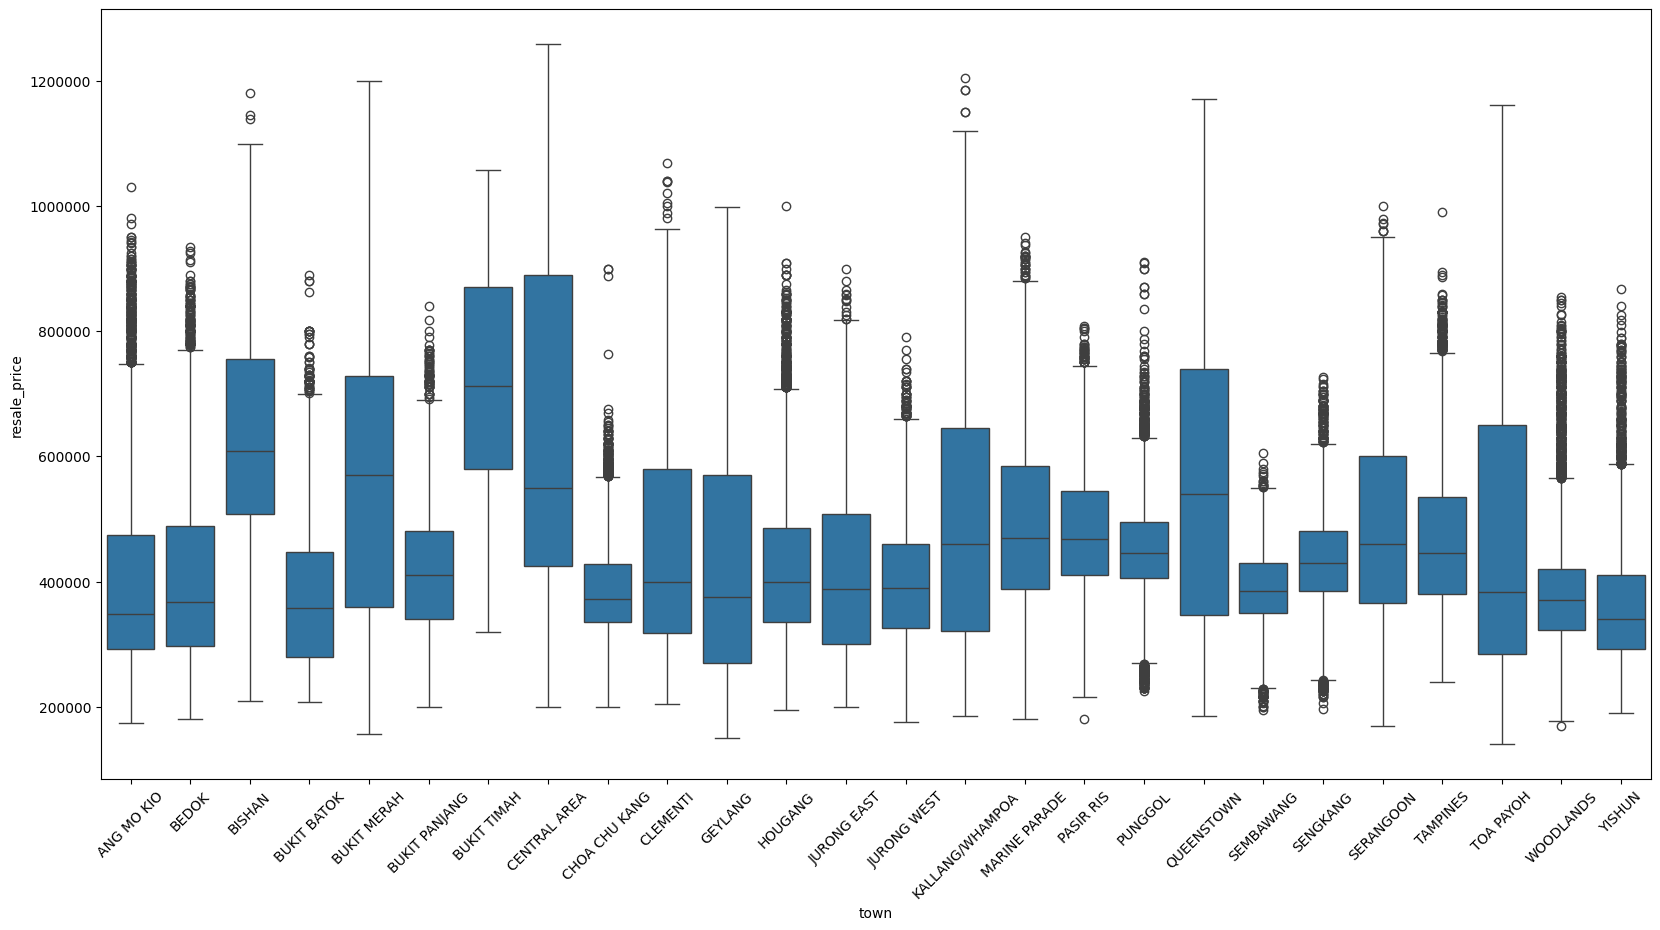

In [19]:
# Boxplots and outliers by 'town'
plt.figure(figsize=(20, 10))
ax1 = sns.boxplot(x='town', y='resale_price', data=df)
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=45)
plt.show()

**Observation:** <br>
- Lowest resale price is 140k dollars in Toa Payoh.
- Highest resale price is 1,258k dollars in Central Area.
- Town that have resale price with median >= 500k dollars (considered as above average):
  - Bishan
  - Bukit Merah
  - Bukit Timah
  - Central Area
  - Queenstown

#### Flat Type vs Resale Price

In [20]:
# Statistical summary by 'flat_type'
df_flat_type = df.groupby('flat_type').describe()['resale_price']
df_flat_type

,count,mean,min,25%,50%,75%,max,std
flat_type,,,,,,,,
1 ROOM,50.0,191365.360000,157000.0,175250.0,189000.0,207250.0,232000.0,19866.775376
2 ROOM,1585.0,235875.442902,150000.0,215000.0,233000.0,250000.0,456888.0,34148.419311
3 ROOM,29404.0,312899.201027,140000.0,270000.0,300000.0,338000.0,1185000.0,69814.451233
4 ROOM,48336.0,433965.562438,218000.0,358888.0,405000.0,468000.0,1186888.0,115341.227977
5 ROOM,28630.0,526387.207265,270000.0,425266.0,480000.0,581763.0,1258000.0,143327.419883
EXECUTIVE,9246.0,624384.074302,390000.0,545000.0,600000.0,685000.0,1160000.0,113749.127713
MULTI-GENERATION,42.0,792989.333333,650000.0,736250.0,784444.0,840000.0,990000.0,80361.079859


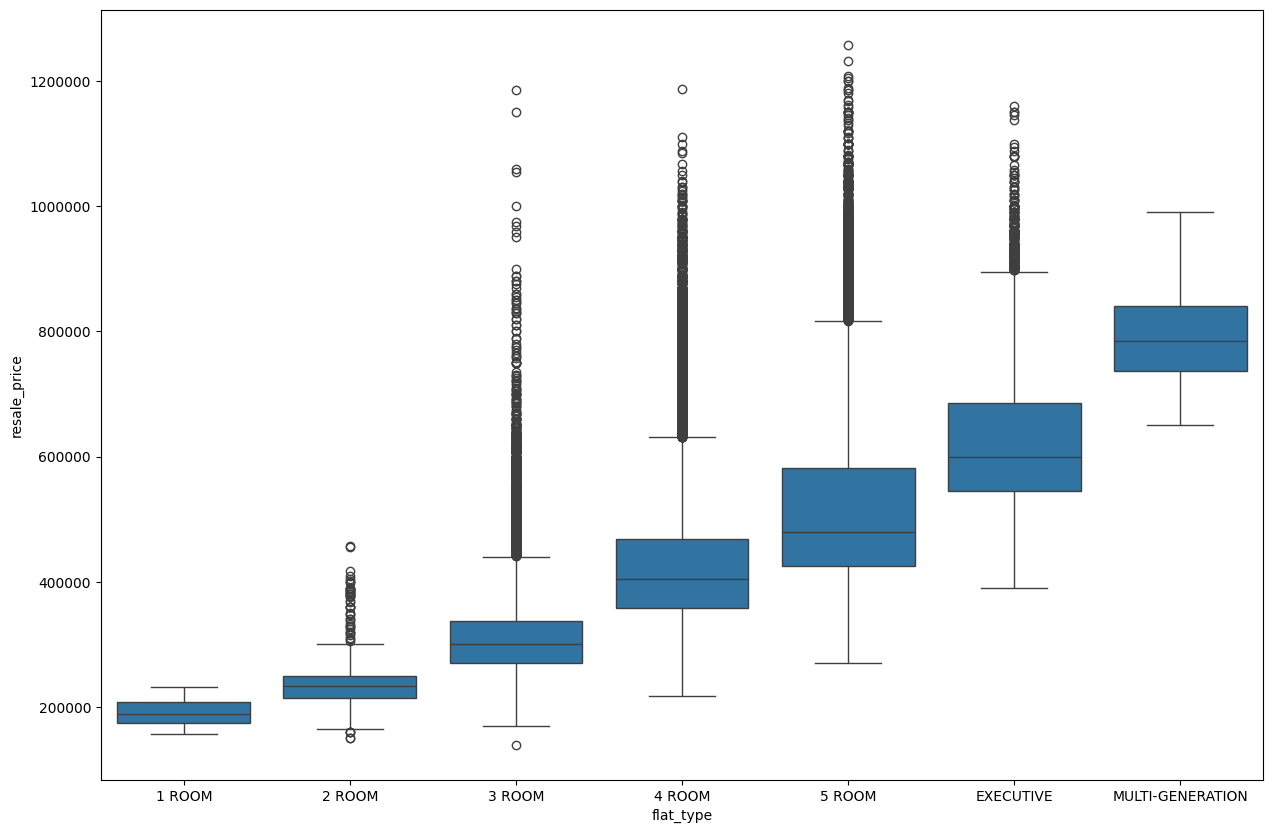

In [21]:
# Boxplots and outliers by 'flat_type'
plt.figure(figsize=(15, 10))
orders = ['1 ROOM', '2 ROOM', '3 ROOM', '4 ROOM', '5 ROOM', 'EXECUTIVE', 'MULTI-GENERATION']
ax1 = sns.boxplot(x='flat_type', y='resale_price', data=df, order=orders)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

**Observation:** <br>
- More Room = Higher Resale Price
- Many outliers = The flat type are not the only features that affect the resale price.

#### Storey Range vs Resale Price

In [22]:
# Statistical summary by 'storey_range'
df_storey_range = df.groupby('storey_range').describe()['resale_price']
df_storey_range

,count,mean,min,25%,50%,75%,max,std
storey_range,,,,,,,,
01 TO 03,21500.0,3.969593e+05,150000.0,308000.0,370000.0,450000.0,1185000.0,127311.655853
04 TO 06,27605.0,4.129589e+05,150000.0,320000.0,388000.0,473000.0,1088000.0,130862.010375
07 TO 09,25105.0,4.247834e+05,165000.0,330000.0,402500.0,488000.0,1055000.0,131254.727679
10 TO 12,22177.0,4.378777e+05,140000.0,340000.0,415000.0,505000.0,1088000.0,137047.371288
13 TO 15,10669.0,4.745314e+05,170000.0,383000.0,448000.0,540000.0,1140000.0,137147.790707
16 TO 18,4702.0,5.176788e+05,180100.0,410000.0,475000.0,612000.0,1050000.0,156009.698242
19 TO 21,1995.0,5.854784e+05,180000.0,438000.0,582000.0,730000.0,1160000.0,185797.033631
22 TO 24,1465.0,6.187677e+05,205000.0,455000.0,610000.0,760000.0,1138000.0,185664.899535
25 TO 27,789.0,6.658404e+05,230000.0,500000.0,685000.0,800000.0,1150000.0,180762.998280


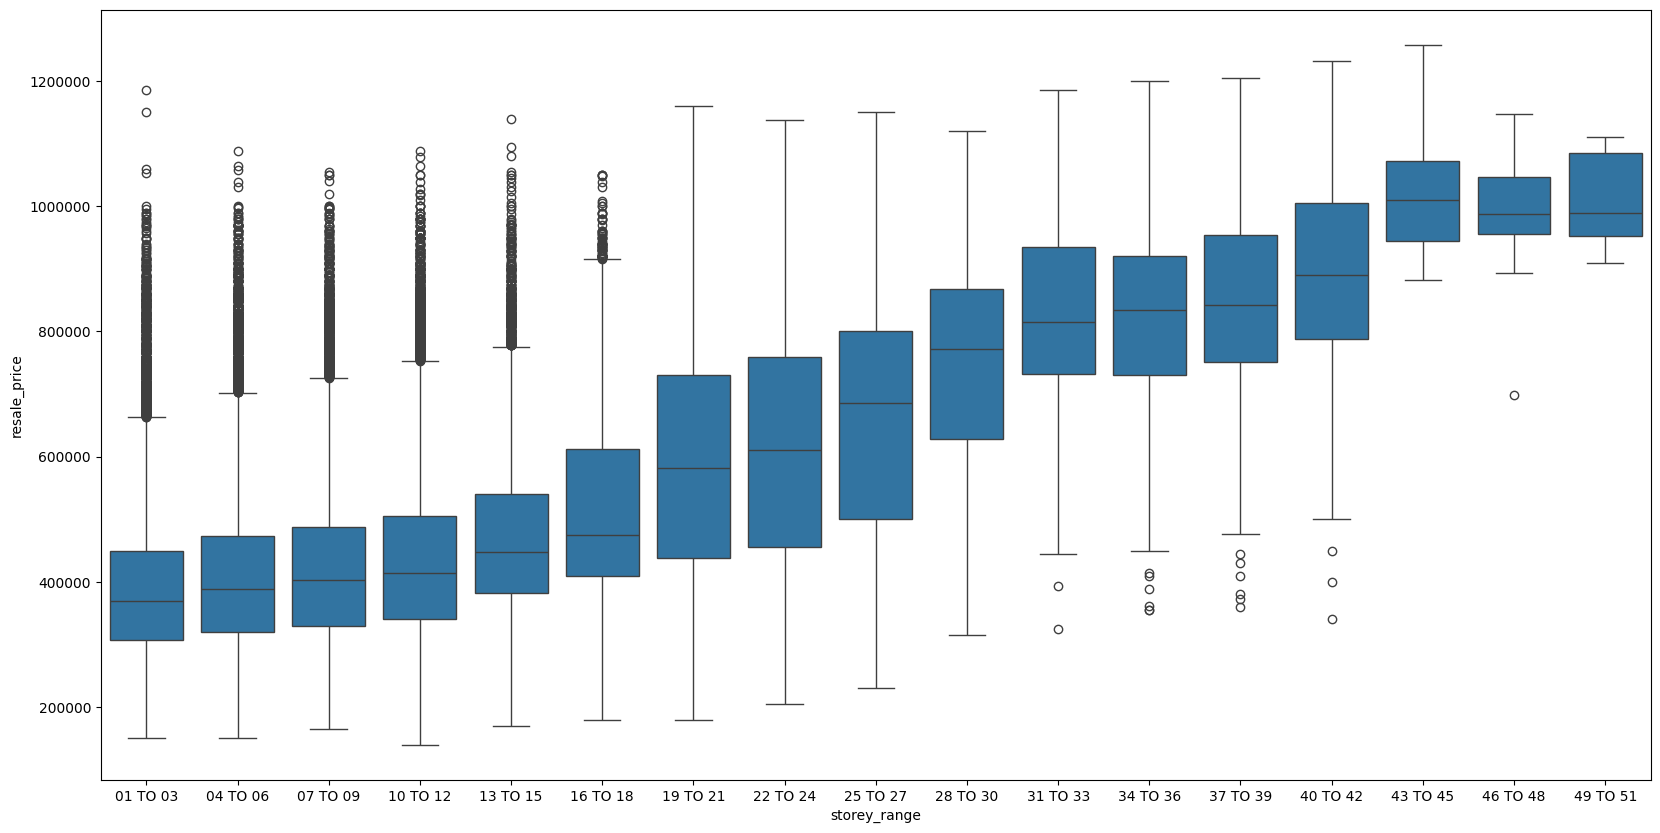

In [23]:
# Boxplots and outliers by 'storey_range'
plt.figure(figsize=(20, 10))
orders=['01 TO 03', '04 TO 06', '07 TO 09', '10 TO 12',
        '13 TO 15', '16 TO 18', '19 TO 21', '22 TO 24',
        '25 TO 27', '28 TO 30', '31 TO 33', '34 TO 36',
        '37 TO 39', '40 TO 42', '43 TO 45', '46 TO 48', '49 TO 51']
ax1 = sns.boxplot(x='storey_range', y='resale_price', data=df, order=orders)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

**Observation:** <br>
- Higher Storey = Higher Resale Price
- Many outliers on storey 01 to 18 = The storey range are not the only features that affect the resale price.

#### Flat Model vs Resale Price

In [24]:
# Statistical summary by 'flat_model'
df_flat_model = df.groupby('flat_model').describe()['resale_price']
df_flat_model

,count,mean,min,25%,50%,75%,max,std
flat_model,,,,,,,,
2-room,3.0,2.330000e+05,227000.0,229500.0,232000.0,236000.0,240000.0,6557.438524
Adjoined flat,202.0,6.808183e+05,375000.0,588500.0,665000.0,780000.0,1088000.0,136350.617478
Apartment,4676.0,6.084367e+05,390000.0,536000.0,590000.0,665000.0,1160000.0,103226.827224
DBSS,1535.0,7.582912e+05,300000.0,650000.0,760000.0,862500.0,1205000.0,153124.413015
Improved,29523.0,4.501329e+05,140000.0,360000.0,435000.0,515000.0,1200000.0,147322.419633
Improved-Maisonette,18.0,6.818827e+05,627000.0,656250.0,677500.0,707500.0,750000.0,34269.826152
Maisonette,3412.0,6.702871e+05,448000.0,580000.0,650000.0,730000.0,1145000.0,117379.399243
Model A,37356.0,4.241301e+05,181000.0,345000.0,395000.0,460000.0,1050000.0,122751.927781
Model A-Maisonette,206.0,7.092751e+05,425000.0,598750.0,707500.0,827500.0,998000.0,149008.725207


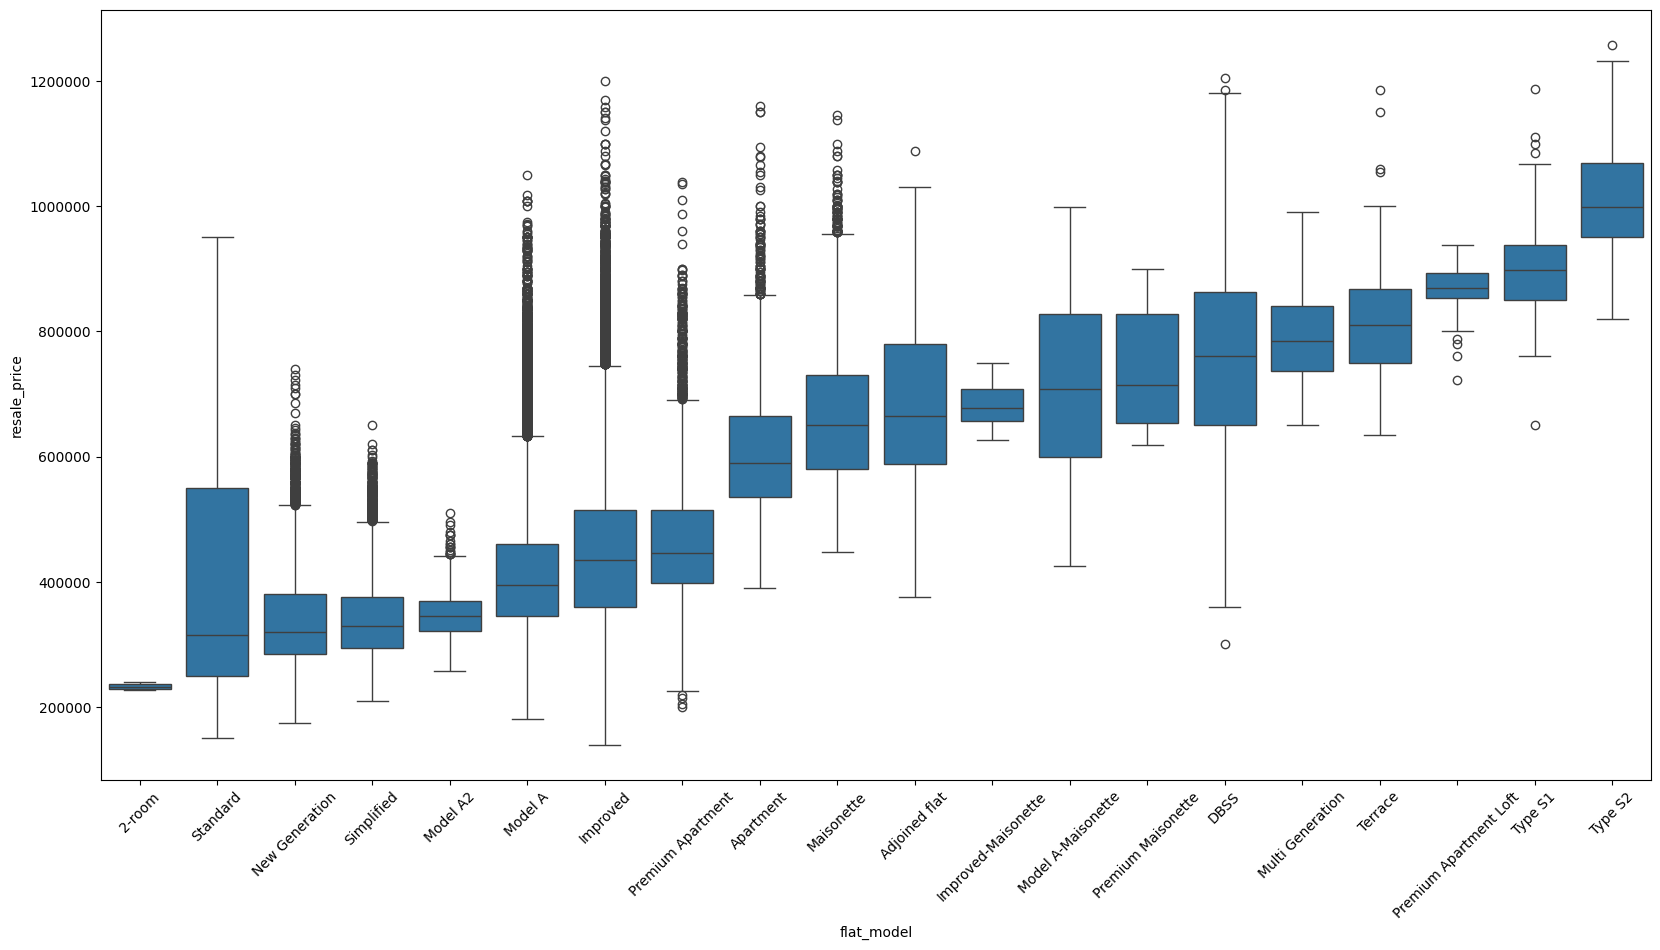

In [25]:
# Boxplots and outliers by 'flat_model'
plt.figure(figsize=(20, 10))
orders = df.groupby('flat_model')['resale_price'].median().sort_values().index
ax1 = sns.boxplot(x='flat_model', y='resale_price', data=df, order=orders)
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=45)
plt.show()

**Observation:** <br>
- Flat type with lowest median resale price = 2-room
- Flat type with highest median resale price = Type S2

#### KDE Plot (for Numerical Data)
KDE plot used to Check Distribution Form

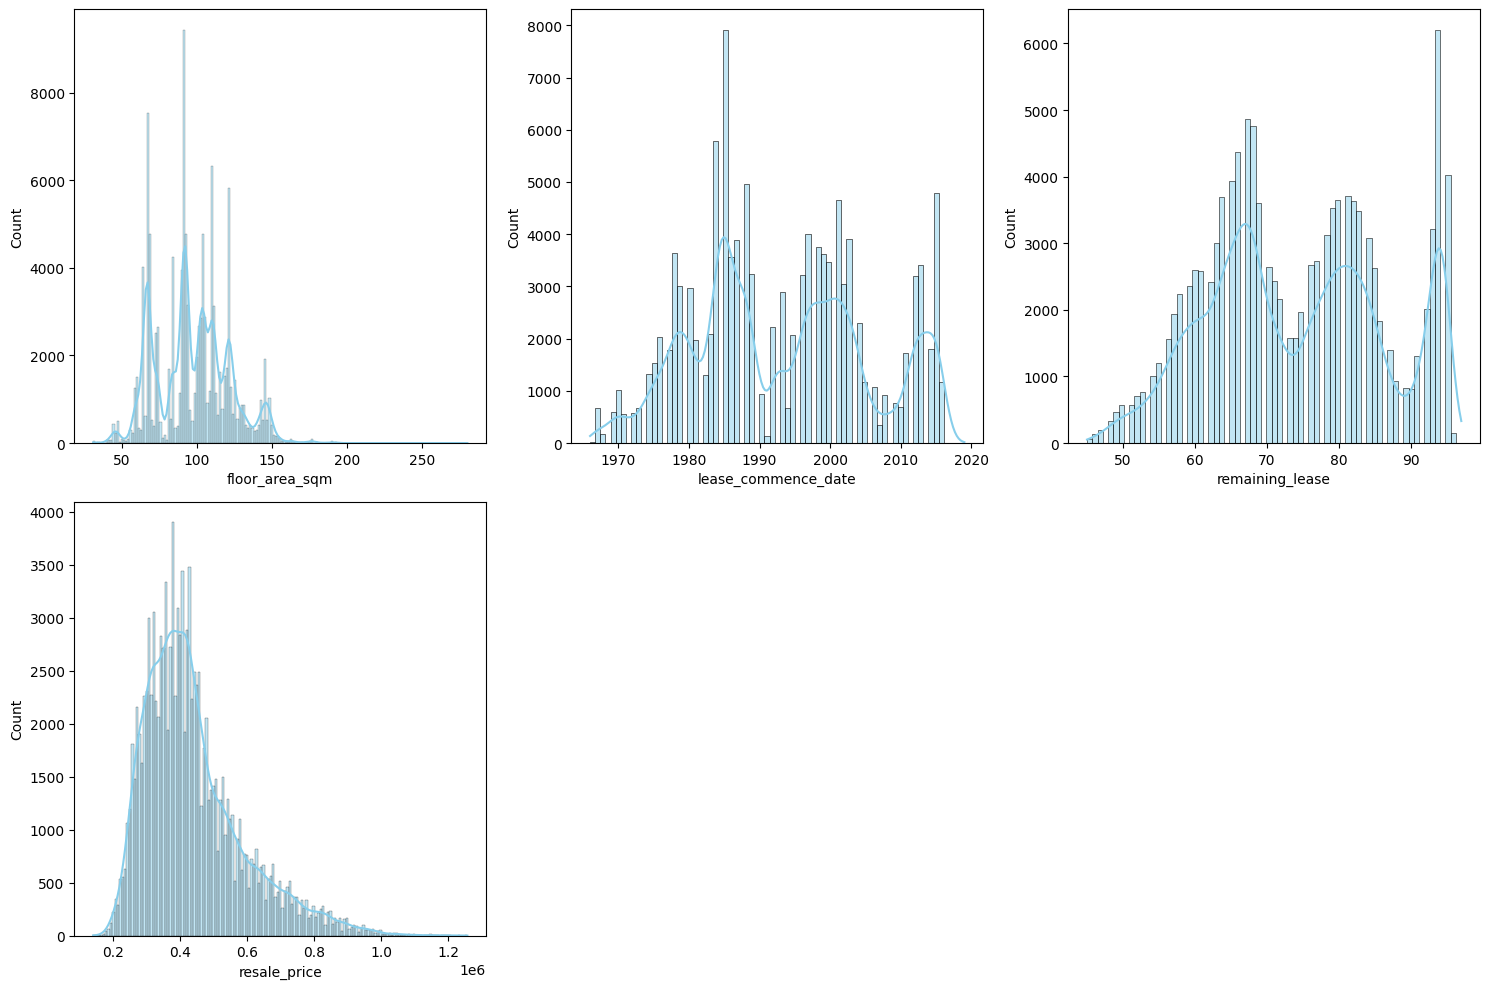

In [26]:
features = numericals
n_cols = 3
n_rows = (len(features) + n_cols - 1) // n_cols
plt.figure(figsize=(n_cols * 5, n_rows * 5))

for i in range(0, len(features)):
    plt.subplot(n_rows, n_cols, i+1)
    sns.histplot(x=df[features[i]], color='skyblue', kde=True)
    plt.xlabel(features[i])
    plt.tight_layout()

**Observation:** <br>
- Resale price distribution is positive skewed

#### Countplot (for Categorical Data)

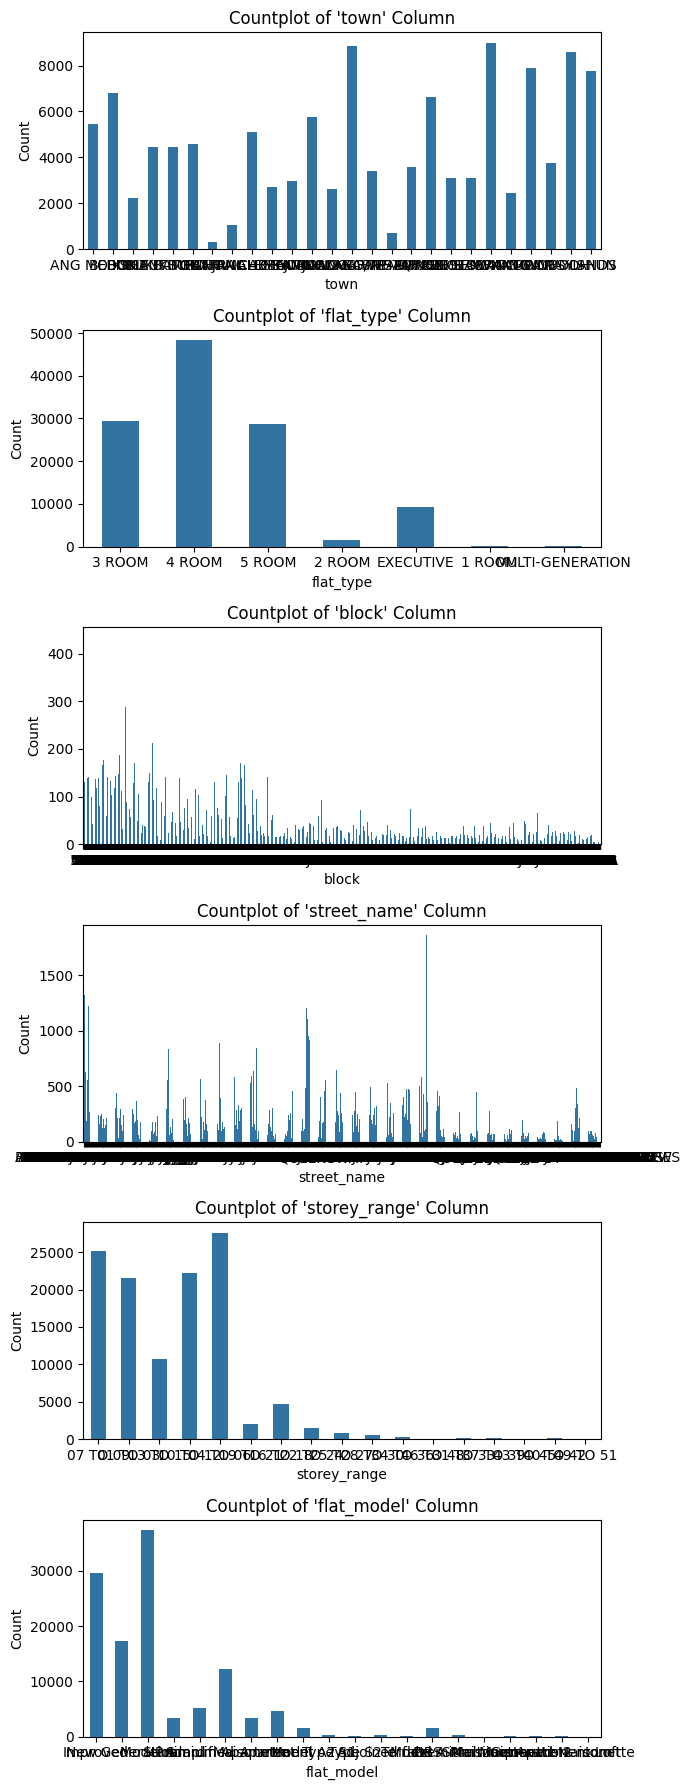

In [27]:
# Adjust plot style
features = categoricals
n_cols = 1
n_rows = (len(features) + n_cols - 1) // n_cols
plt.figure(figsize=(n_cols * 7, n_rows * 3))

# Plotting
for i in range(0, len(features)):
  plt.subplot(n_rows, n_cols, i + 1)
  sns.countplot(x=df[features[i]], width=0.5)
  plt.title(f"Countplot of '{features[i]}' Column")
  plt.ylabel('Count')
  plt.tight_layout()

### Multivariate Analysis
*On training set only*

#### Multicollinearity Study (for Numerical Data)

In [28]:
# Calculate VIF scores for each feature
X = add_constant(df[numericals])

vif_df = pd.DataFrame([vif(X.values, i)
               for i in range(X.shape[1])],
              index=X.columns).reset_index()
vif_df.columns = ['Feature', 'VIF_score']
vif_df = vif_df.loc[vif_df.Feature!='const']
vif_df

,Feature,VIF_score
1,floor_area_sqm,1.692382
2,lease_commence_date,53.664560
3,remaining_lease,53.809005
4,resale_price,1.796570


**Observation:** <br>
Threshold: VIF > 10 -> Severe Multicollinearity
- Severe multicollinearity on `lease_commence_date` and `remaining_lease`
- Check heatmap plot for more details

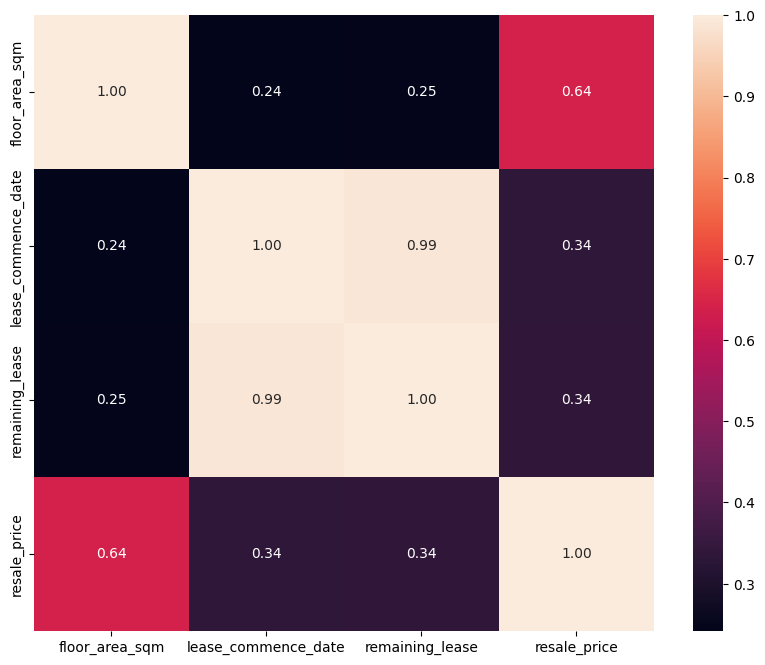

In [29]:
# Heatmap plot
plt.figure(figsize=(10, 8))
correlation = df[numericals].corr() # Gets correlation of numerical data in dataframe
sns.heatmap(correlation, annot=True, fmt='.2f')
plt.show()

**Observation:** <br>
Threshold: abs(corr) >= 0.80

From the heatmap above, it can be observed that the features `lease_commence_date` and `remaining_lease` have a very strong positive correlation of 0.99, which above the threshold. Therefore, only one of these features needs to be retained (will be dropped after splitting the data).

## Pre-Split Feature Engineering

#### Create the Distance Feature (Numerical)
- Create the distance feature before splitting data is safe to do, because distance is exact data.
- The location of a flat can be one of the features that influences the resale price.
- Reference:
  - Main Web: https://www.onemap.gov.sg/
  - API for latitude & longitude: https://www.onemap.gov.sg/apidocs/search

Interesting locations for further analysis: <br>
- Dhoby Ghaut:
  - Location: Located in the city center.
  - Crowd Level: Crowded with visitors because it has many malls and entertainment venues.
  - Transportation: Has 3 MRT access routes, namely NSL, NEL, and CCL.
- Raffles Place:
  - Location: Is a Central Business District (CBD) that has many large companies and banks.
  - Crowd Level: Crowded on weekdays.
  - Transportation: Has 2 MRT access routes, namely NSL and EWL.

##### Get the Latitude and Longitude of HDB

In [30]:
df['address'] = df['block'] + ' ' + df['street_name']
addresslist = list(df['address'])

In [31]:
# Use a session object to reuse connections
session = requests.Session()

# Function to get coordinates
def getcoordinates(address):
    url = f'https://www.onemap.gov.sg/api/common/elastic/search?searchVal={address}&returnGeom=Y&getAddrDetails=Y&pageNum=1'
    try:
        response = session.get(url, timeout=5)
        data = response.json()
        if data.get('results'):
            return data['results'][0]['LATITUDE'], data['results'][0]['LONGITUDE']
    except Exception as e:
        print(f'Failed to extract {address}: {e}')
    return '', '' # No Latitude and Longitude if error

In [32]:
# %%time

# # Function to fetch coordinates in parallel
# def fetch_coordinates_parallel(addresslist, max_workers=10):
#     coordinateslist = []
#     failed_count = 0

#     with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
#         results = list(executor.map(getcoordinates, addresslist))

#     for i, result in enumerate(results):
#         if result:
#             print(f'Extracting {i+1} out of {len(addresslist)} addresses')
#             coordinateslist.append(result)
#         else:
#             print(f'Failed to extract {i+1} out of {len(addresslist)} addresses')
#             failed_count += 1
#             coordinateslist.append(None)

#     print('Total Number of Addresses With No Coordinates:', failed_count)
#     return coordinateslist

# # Call the function with threading
# coordinateslist = fetch_coordinates_parallel(addresslist, max_workers=20)

In [33]:
# # Convert coordinateslist to DataFrame and reset index
# df_coordinates = pd.DataFrame(coordinateslist, columns=['Latitude', 'Longitude']).reset_index(drop=True)

# # Ensure df also has a reset index to maintain order
# df = df.reset_index(drop=True)

# # Merge based on row order, avoiding index mismatches
# df_combined = pd.concat([df, df_coordinates], axis=1)

# # Save to CSV
# df_combined.to_csv('address_coordinates.csv', index=False)

This dataset has been saved to a CSV, so it can be used without needing to call the API again.

In [34]:
df_new = pd.read_csv('https://raw.githubusercontent.com/valdo28/singaporehdb/refs/heads/main/dataset/address_coordinates.csv')
df_new

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,address,Latitude,Longitude
0,2015-01-01,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,07 TO 09,60,Improved,1986,70,255000,174 ANG MO KIO AVE 4,1.375097,103.837619
1,2015-01-01,ANG MO KIO,3 ROOM,541,ANG MO KIO AVE 10,01 TO 03,68,New Generation,1981,65,275000,541 ANG MO KIO AVE 10,1.373922,103.855621
2,2015-01-01,ANG MO KIO,3 ROOM,163,ANG MO KIO AVE 4,01 TO 03,69,New Generation,1980,64,285000,163 ANG MO KIO AVE 4,1.373549,103.838176
3,2015-01-01,ANG MO KIO,3 ROOM,446,ANG MO KIO AVE 10,01 TO 03,68,New Generation,1979,63,290000,446 ANG MO KIO AVE 10,1.367761,103.855357
4,2015-01-01,ANG MO KIO,3 ROOM,557,ANG MO KIO AVE 10,07 TO 09,68,New Generation,1980,64,290000,557 ANG MO KIO AVE 10,1.371626,103.857736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117288,2020-09-01,YISHUN,5 ROOM,716,YISHUN ST 71,07 TO 09,131,Improved,1987,66,440000,716 YISHUN ST 71,1.426211,103.827704
117289,2020-09-01,YISHUN,5 ROOM,760,YISHUN ST 72,07 TO 09,122,Improved,1987,65,458000,760 YISHUN ST 72,1.425795,103.832725
117290,2020-09-01,YISHUN,5 ROOM,835,YISHUN ST 81,04 TO 06,122,Improved,1987,66,490000,835 YISHUN ST 81,1.415110,103.833415
117291,2020-09-01,YISHUN,EXECUTIVE,791,YISHUN AVE 2,04 TO 06,146,Maisonette,1987,66,558000,791 YISHUN AVE 2,1.420520,103.833564


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 117293 entries, 0 to 80373
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   month                117293 non-null  datetime64[ns]
 1   town                 117293 non-null  object        
 2   flat_type            117293 non-null  object        
 3   block                117293 non-null  object        
 4   street_name          117293 non-null  object        
 5   storey_range         117293 non-null  object        
 6   floor_area_sqm       117293 non-null  int64         
 7   flat_model           117293 non-null  object        
 8   lease_commence_date  117293 non-null  int64         
 9   remaining_lease      117293 non-null  int64         
 10  resale_price         117293 non-null  int64         
 11  address              117293 non-null  object        
dtypes: datetime64[ns](1), int64(4), object(7)
memory usage: 11.6+ MB


In [36]:
# Check missing latitude and longitude
df_new['Latitude'].isna().sum()

29

In [37]:
# Handle missing latitude and longitude
df_new = df_new.dropna()

##### Get the Latitude and Longitude of Dhoby Ghaut MRT Station
- Singapore MRT Stations: https://en.wikipedia.org/wiki/List_of_Singapore_MRT_stations

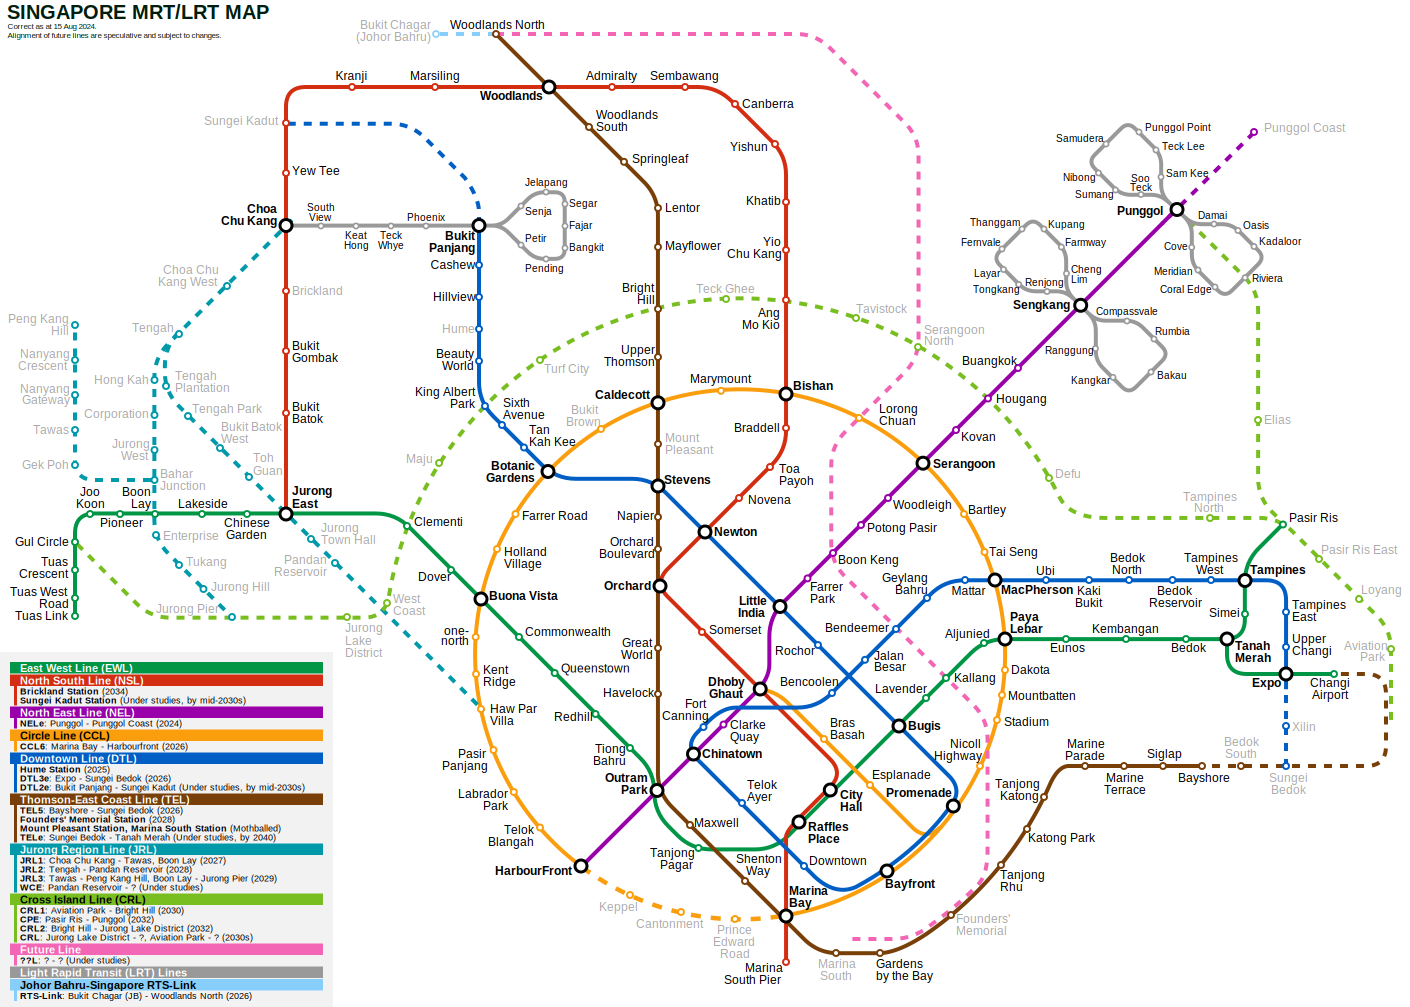

In [38]:
display(SVG(url='https://upload.wikimedia.org/wikipedia/commons/6/68/Singapore_MRT_and_LRT_System_Map.svg'))

**Dhoby Ghaut MRT** <br>
Address: 13 ORCHARD ROAD DHOBY GHAUT MRT STATION (CC1) SINGAPORE 238893

In [39]:
dhoby_mrt_coordinates = getcoordinates('13 ORCHARD ROAD DHOBY GHAUT MRT STATION (CC1) SINGAPORE 238893')
dhoby_mrt_coordinates

('1.29891164362677', '103.84629250696')

##### Get the Latitude and Longitude of Raffles City Mall

**Raffles City Shopping Centre** <br>
Address: 252 NORTH BRIDGE ROAD RAFFLES CITY SHOPPING CENTRE SINGAPORE 179103

In [40]:
raffles_city_coordinates = getcoordinates('252 NORTH BRIDGE ROAD RAFFLES CITY SHOPPING CENTRE SINGAPORE 179103')
raffles_city_coordinates

('1.29389357863312', '103.853119904656')

##### Calculate Distance
Reference: https://geopy.readthedocs.io/en/stable/#module-geopy.distance

In [41]:
# Create tuple of latitude and longitude to calculate distance
df_new['Lat_Long'] = tuple(zip(df_new['Latitude'], df_new['Longitude']))
df_new

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,address,Latitude,Longitude,Lat_Long
0,2015-01-01,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,07 TO 09,60,Improved,1986,70,255000,174 ANG MO KIO AVE 4,1.375097,103.837619,"(1.37509746867904, 103.83761896123)"
1,2015-01-01,ANG MO KIO,3 ROOM,541,ANG MO KIO AVE 10,01 TO 03,68,New Generation,1981,65,275000,541 ANG MO KIO AVE 10,1.373922,103.855621,"(1.37392239168826, 103.855621371068)"
2,2015-01-01,ANG MO KIO,3 ROOM,163,ANG MO KIO AVE 4,01 TO 03,69,New Generation,1980,64,285000,163 ANG MO KIO AVE 4,1.373549,103.838176,"(1.37354853919927, 103.838176471398)"
3,2015-01-01,ANG MO KIO,3 ROOM,446,ANG MO KIO AVE 10,01 TO 03,68,New Generation,1979,63,290000,446 ANG MO KIO AVE 10,1.367761,103.855357,"(1.36776095130953, 103.855357145908)"
4,2015-01-01,ANG MO KIO,3 ROOM,557,ANG MO KIO AVE 10,07 TO 09,68,New Generation,1980,64,290000,557 ANG MO KIO AVE 10,1.371626,103.857736,"(1.3716257020332, 103.857736107527)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117288,2020-09-01,YISHUN,5 ROOM,716,YISHUN ST 71,07 TO 09,131,Improved,1987,66,440000,716 YISHUN ST 71,1.426211,103.827704,"(1.42621096565013, 103.827704108295)"
117289,2020-09-01,YISHUN,5 ROOM,760,YISHUN ST 72,07 TO 09,122,Improved,1987,65,458000,760 YISHUN ST 72,1.425795,103.832725,"(1.42579485526292, 103.832724670537)"
117290,2020-09-01,YISHUN,5 ROOM,835,YISHUN ST 81,04 TO 06,122,Improved,1987,66,490000,835 YISHUN ST 81,1.415110,103.833415,"(1.41511032968933, 103.83341538078)"
117291,2020-09-01,YISHUN,EXECUTIVE,791,YISHUN AVE 2,04 TO 06,146,Maisonette,1987,66,558000,791 YISHUN AVE 2,1.420520,103.833564,"(1.42051978046189, 103.833564417845)"


In [42]:
# Function to calculate distance
def distance(flat_lat_long, destination_lat_long):
  flat_coordinates = flat_lat_long
  destination_coordinates = destination_lat_long
  distance = geodesic(flat_coordinates, destination_coordinates).km
  # print(f"Distance: {distance:.2f} km")
  return distance

In [43]:
# Create new feature -> calculate distance from flat to MRT (km)
df_new['distance_to_mrt'] = df_new['Lat_Long'].apply(lambda x: distance(x, dhoby_mrt_coordinates))

# Create new feature -> calculate distance from flat to Mall (km)
df_new['distance_to_mall'] = df_new['Lat_Long'].apply(lambda x: distance(x, raffles_city_coordinates))

In [44]:
df_new

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,address,Latitude,Longitude,Lat_Long,distance_to_mrt,distance_to_mall
0,2015-01-01,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,07 TO 09,60,Improved,1986,70,255000,174 ANG MO KIO AVE 4,1.375097,103.837619,"(1.37509746867904, 103.83761896123)",8.479360,9.143323
1,2015-01-01,ANG MO KIO,3 ROOM,541,ANG MO KIO AVE 10,01 TO 03,68,New Generation,1981,65,275000,541 ANG MO KIO AVE 10,1.373922,103.855621,"(1.37392239168826, 103.855621371068)",8.359028,8.853554
2,2015-01-01,ANG MO KIO,3 ROOM,163,ANG MO KIO AVE 4,01 TO 03,69,New Generation,1980,64,285000,163 ANG MO KIO AVE 4,1.373549,103.838176,"(1.37354853919927, 103.838176471398)",8.302245,8.963466
3,2015-01-01,ANG MO KIO,3 ROOM,446,ANG MO KIO AVE 10,01 TO 03,68,New Generation,1979,63,290000,446 ANG MO KIO AVE 10,1.367761,103.855357,"(1.36776095130953, 103.855357145908)",7.679551,8.171669
4,2015-01-01,ANG MO KIO,3 ROOM,557,ANG MO KIO AVE 10,07 TO 09,68,New Generation,1980,64,290000,557 ANG MO KIO AVE 10,1.371626,103.857736,"(1.3716257020332, 103.857736107527)",8.140586,8.610559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117288,2020-09-01,YISHUN,5 ROOM,716,YISHUN ST 71,07 TO 09,131,Improved,1987,66,440000,716 YISHUN ST 71,1.426211,103.827704,"(1.42621096565013, 103.827704108295)",14.227307,14.901877
117289,2020-09-01,YISHUN,5 ROOM,760,YISHUN ST 72,07 TO 09,122,Improved,1987,65,458000,760 YISHUN ST 72,1.425795,103.832725,"(1.42579485526292, 103.832724670537)",14.111116,14.760526
117290,2020-09-01,YISHUN,5 ROOM,835,YISHUN ST 81,04 TO 06,122,Improved,1987,66,490000,835 YISHUN ST 81,1.415110,103.833415,"(1.41511032968933, 103.83341538078)",12.928330,13.581729
117291,2020-09-01,YISHUN,EXECUTIVE,791,YISHUN AVE 2,04 TO 06,146,Maisonette,1987,66,558000,791 YISHUN AVE 2,1.420520,103.833564,"(1.42051978046189, 103.833564417845)",13.521208,14.169803


#### Drop Irrelevant Columns

In [45]:
df_new = df_new.drop(['month', 'block', 'street_name', 'address', 'Latitude', 'Longitude', 'Lat_Long'], axis=1)

In [46]:
df_new

,town,flat_type,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,distance_to_mrt,distance_to_mall
0,ANG MO KIO,3 ROOM,07 TO 09,60,Improved,1986,70,255000,8.479360,9.143323
1,ANG MO KIO,3 ROOM,01 TO 03,68,New Generation,1981,65,275000,8.359028,8.853554
2,ANG MO KIO,3 ROOM,01 TO 03,69,New Generation,1980,64,285000,8.302245,8.963466
3,ANG MO KIO,3 ROOM,01 TO 03,68,New Generation,1979,63,290000,7.679551,8.171669
4,ANG MO KIO,3 ROOM,07 TO 09,68,New Generation,1980,64,290000,8.140586,8.610559
...,...,...,...,...,...,...,...,...,...,...
117288,YISHUN,5 ROOM,07 TO 09,131,Improved,1987,66,440000,14.227307,14.901877
117289,YISHUN,5 ROOM,07 TO 09,122,Improved,1987,65,458000,14.111116,14.760526
117290,YISHUN,5 ROOM,04 TO 06,122,Improved,1987,66,490000,12.928330,13.581729
117291,YISHUN,EXECUTIVE,04 TO 06,146,Maisonette,1987,66,558000,13.521208,14.169803


## Split Data

In [47]:
# Separate feature as X and target as y
X = df_new.drop('resale_price', axis=1)
y = df_new['resale_price']

In [48]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check train and test data shape
X_train.shape, X_test.shape

((93811, 9), (23453, 9))

## Post-Split Exploratory Data Analysis (EDA)

### Statistical Summary

In [49]:
# Grouping data
numericals = X_train.select_dtypes(include=['number']).columns.to_list()
categoricals = X_train.select_dtypes(include=['object']).columns.to_list()

In [50]:
# Numericals statistical summary
X_train[numericals].describe().T

,count,mean,std,min,25%,50%,75%,max
floor_area_sqm,93811.0,97.407362,24.267597,31.000000,77.000000,95.000000,112.000000,280.000000
lease_commence_date,93811.0,1993.100372,12.337313,1966.000000,1984.000000,1993.000000,2002.000000,2019.000000
remaining_lease,93811.0,74.126201,12.235699,45.000000,65.000000,73.000000,83.000000,97.000000
distance_to_mrt,93811.0,11.240369,4.199275,0.620537,8.355449,12.185215,14.376060,18.608348
distance_to_mall,93811.0,11.632220,4.370535,0.328229,8.620476,12.422553,14.878241,19.403699


In [51]:
# Categoricals statistical summary
X_train[categoricals].describe().T

,count,unique,top,freq
town,93811,26,SENGKANG,7242
flat_type,93811,7,4 ROOM,38592
storey_range,93811,17,04 TO 06,22143
flat_model,93811,20,Model A,29869


### Univariate Analysis

#### Outliers Detection
Using Boxplot

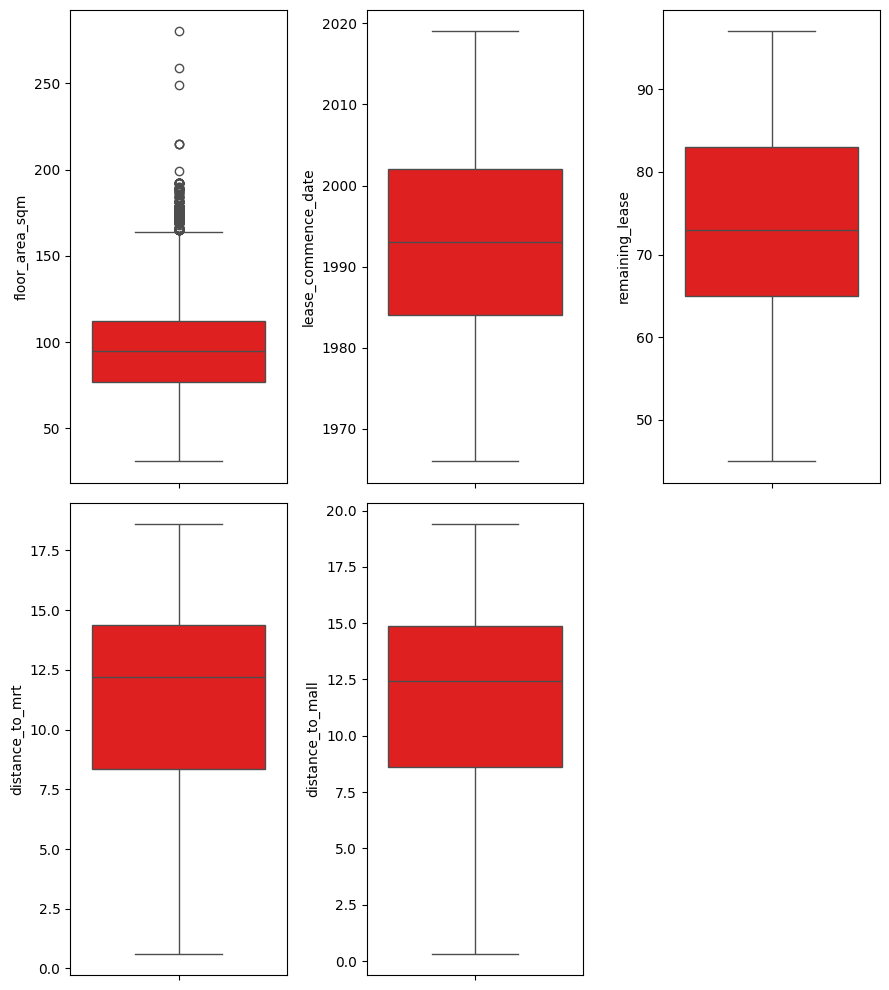

In [52]:
features = numericals
n_cols = 3
n_rows = (len(features) + n_cols - 1) // n_cols
plt.figure(figsize=(n_cols * 3, n_rows * 5))

for i in range(0, len(features)):
    plt.subplot(n_rows, n_cols, i+1)
    sns.boxplot(y=X_train[features[i]], color='red')
    plt.tight_layout()

**Observation:** <br>
- `floor_area_sqm`: There are many outliers above the upper whisker, indicating some houses have much larger floor areas (above 150 sqm, with some exceeding 250 sqm).
- `lease_commence_date`: No significant outliers, meaning lease commencement dates are evenly distributed.
- `remaining_lease`: No significant outliers, meaning remaining lease are evenly distributed.
- `distance_to_mrt`: No significant outliers, meaning distance from HDB to Dhoby Ghaut MRT station are evenly distributed.
- `distance_to_mall`: No significant outliers, meaning distance from HDB to Raffles City Mall are evenly distributed.

### Multivariate Analysis

#### Multicollinearity Study (for Numerical Data)

In [53]:
# Grouping data
numericals = X_train.select_dtypes(include=['number']).columns.to_list()
categoricals = X_train.select_dtypes(include=['object']).columns.to_list()

In [54]:
# Calculate VIF scores for each feature
X = add_constant(X_train[numericals])

vif_df = pd.DataFrame([vif(X.values, i)
               for i in range(X.shape[1])],
              index=X.columns).reset_index()
vif_df.columns = ['Feature', 'VIF_score']
vif_df = vif_df.loc[vif_df.Feature!='const']
vif_df

,Feature,VIF_score
1,floor_area_sqm,1.119832
2,lease_commence_date,53.698484
3,remaining_lease,53.851615
4,distance_to_mrt,91.821911
5,distance_to_mall,91.373272


**Observation:** <br>
Threshold: VIF > 10 -> Severe Multicollinearity
- Severe multicollinearity on `lease_commence_date`, `remaining_lease`, `distance_to_mrt`, and `distance_to_mall`
- Check heatmap plot for more details

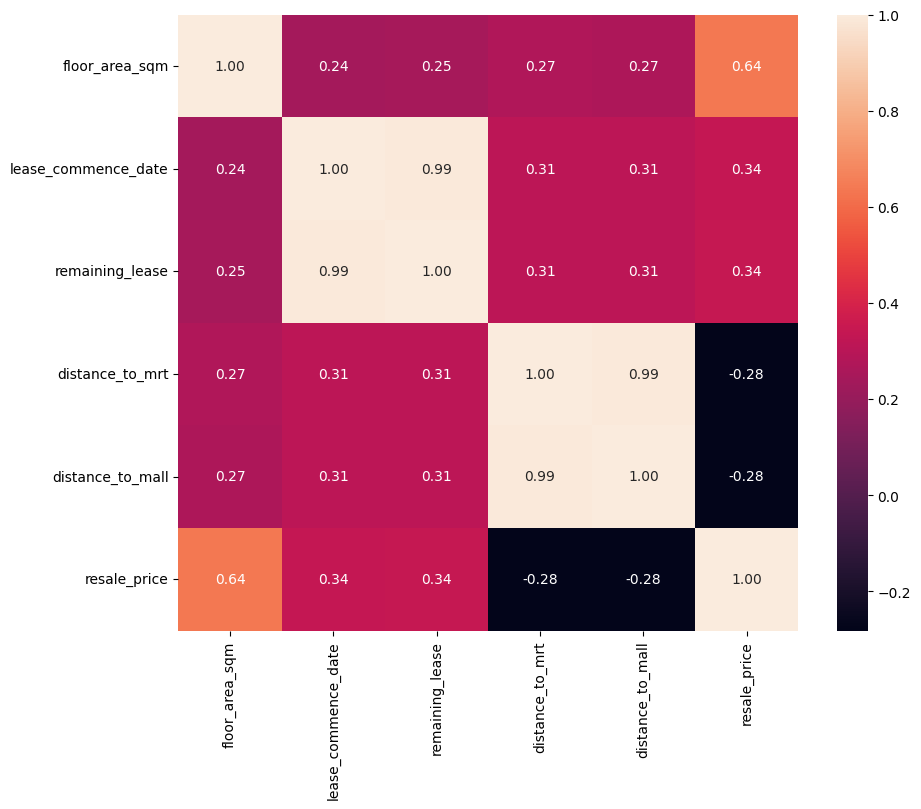

In [55]:
# Heatmap plot
plt.figure(figsize=(10, 8))
df_corr = pd.concat([X_train[numericals], y_train], axis=1)
correlation = df_corr.corr() # Gets correlation of numerical data in dataframe
sns.heatmap(correlation, annot=True, fmt='.2f')
plt.show()

In [56]:
# Correlation with target 'resale_price' (absolute value)
abs_target_corr = df_corr.corr()['resale_price'].abs().sort_values(ascending=False)
abs_target_corr

,resale_price
resale_price,1.000000
floor_area_sqm,0.638605
remaining_lease,0.341173
lease_commence_date,0.338057
distance_to_mall,0.281901
distance_to_mrt,0.280020


**Observation:** <br>
Threshold: abs(corr) >= 0.80
- `lease_commence_date` and `remaining_lease`:
  - From the heatmap above, it can be observed that the features `lease_commence_date` and `remaining_lease` have a very strong positive correlation of 0.99, which above the threshold. Therefore, only one of these features needs to be retained.
  - The retained feature is the one with a stronger correlation to the target `resale_price`, whether positive or negative (absolute value). Since the correlation of `remaining_lease` with the target `resale_price` is stronger than `lease_commence_date`, the decision in this analysis is to drop `lease_commence_date`.

- `distance_to_mrt` and `distance_to_mall`:
  - New features created, `distance_to_mrt` and `distance_to_mall` actually has a strong correlation with positive correlation of 0.99, which above the threshold. Therefore, only one of these features needs to be retained.
  - The decision in this analysis is to drop `distance_to_mall`.

In [57]:
# Drop redundant features
X_train = X_train.drop(['lease_commence_date', 'distance_to_mall'], axis=1)
X_test = X_test.drop(['lease_commence_date', 'distance_to_mall'], axis=1)

In [58]:
X_train

,town,flat_type,storey_range,floor_area_sqm,flat_model,remaining_lease,distance_to_mrt
82182,BUKIT MERAH,4 ROOM,04 TO 06,108,Model A,76,3.033292
74436,HOUGANG,4 ROOM,07 TO 09,98,Model A,77,9.793300
114418,TAMPINES,EXECUTIVE,01 TO 03,165,Apartment,72,13.826044
98374,PASIR RIS,EXECUTIVE,01 TO 03,159,Apartment,74,14.762039
107068,YISHUN,3 ROOM,07 TO 09,74,Model A,67,14.541301
...,...,...,...,...,...,...,...
76849,QUEENSTOWN,3 ROOM,01 TO 03,65,Improved,54,5.750939
110297,BUKIT MERAH,3 ROOM,07 TO 09,54,Standard,48,1.985430
103723,HOUGANG,5 ROOM,07 TO 09,113,Improved,94,10.685839
860,SENGKANG,3 ROOM,04 TO 06,68,Model A,95,11.020357


**Re-check Multicollinearity After Drop**

In [59]:
# Re-grouping data
numericals = X_train.select_dtypes(include=['number']).columns.to_list()

# Re-calculate VIF scores for each feature
X = add_constant(X_train[numericals])

vif_df = pd.DataFrame([vif(X.values, i)
               for i in range(X.shape[1])],
              index=X.columns).reset_index()
vif_df.columns = ['Feature', 'VIF_score']
vif_df = vif_df.loc[vif_df.Feature!='const']
vif_df

,Feature,VIF_score
1,floor_area_sqm,1.116079
2,remaining_lease,1.145100
3,distance_to_mrt,1.162296


**Observation:** <br>
Good! There are no longer any correlated features.

## Post-Split Feature Engineering

#### Create Region Feature (Categorical)
- Town unique values are to much for modeling. Therefore, better to group the town into region.
- Reference: https://en.wikipedia.org/wiki/Regions_of_Singapore#List_of_regions

In [60]:
# Check unique town list on dataset
X_train['town'].unique()

array(['BUKIT MERAH', 'HOUGANG', 'TAMPINES', 'PASIR RIS', 'YISHUN',
       'SEMBAWANG', 'TOA PAYOH', 'CENTRAL AREA', 'GEYLANG', 'SENGKANG',
       'BISHAN', 'WOODLANDS', 'BUKIT PANJANG', 'PUNGGOL', 'CHOA CHU KANG',
       'JURONG WEST', 'JURONG EAST', 'QUEENSTOWN', 'KALLANG/WHAMPOA',
       'ANG MO KIO', 'SERANGOON', 'CLEMENTI', 'BEDOK', 'BUKIT BATOK',
       'BUKIT TIMAH', 'MARINE PARADE'], dtype=object)

In [61]:
# Create region feature
def town_to_region(town):
    if town in ['SEMBAWANG', 'SENGKANG', 'WOODLANDS', 'YISHUN']:
        return 'NORTH'
    elif town in ['BUKIT MERAH', 'BUKIT TIMAH', 'QUEENSTOWN']:
        return 'SOUTH'
    elif town in ['BEDOK', 'GEYLANG', 'HOUGANG', 'KALLANG/WHAMPOA', 'PASIR RIS', 'PUNGGOL', 'SERANGOON', 'TAMPINES']:
        return 'EAST'
    elif town in ['BUKIT BATOK', 'BUKIT PANJANG', 'CHOA CHU KANG', 'CLEMENTI', 'JURONG EAST', 'JURONG WEST']:
        return 'WEST'
    elif town in ['ANG MO KIO', 'BISHAN', 'CENTRAL AREA', 'MARINE PARADE', 'TOA PAYOH']:
        return 'CENTRAL'
    else:
        return 'UNKNOWN'

X_train['region'] = X_train['town'].apply(town_to_region)
X_test['region'] = X_test['town'].apply(town_to_region)

# Drop town feature
X_train = X_train.drop('town', axis=1)
X_test = X_test.drop('town', axis=1)

## Feature Encoding

In [62]:
# Check data for encoding
X_train

,flat_type,storey_range,floor_area_sqm,flat_model,remaining_lease,distance_to_mrt,region
82182,4 ROOM,04 TO 06,108,Model A,76,3.033292,SOUTH
74436,4 ROOM,07 TO 09,98,Model A,77,9.793300,EAST
114418,EXECUTIVE,01 TO 03,165,Apartment,72,13.826044,EAST
98374,EXECUTIVE,01 TO 03,159,Apartment,74,14.762039,EAST
107068,3 ROOM,07 TO 09,74,Model A,67,14.541301,NORTH
...,...,...,...,...,...,...,...
76849,3 ROOM,01 TO 03,65,Improved,54,5.750939,SOUTH
110297,3 ROOM,07 TO 09,54,Standard,48,1.985430,SOUTH
103723,5 ROOM,07 TO 09,113,Improved,94,10.685839,EAST
860,3 ROOM,04 TO 06,68,Model A,95,11.020357,NORTH


In [63]:
# Examine the contents of categorical data to determine the type of encoding to use
for col in X_train.columns:
  print(f'Unique value of {col}:')
  print(f'{X_train[col].unique()}\n')

Unique value of flat_type:
['4 ROOM' 'EXECUTIVE' '3 ROOM' '5 ROOM' '2 ROOM' '1 ROOM'
 'MULTI-GENERATION']

Unique value of storey_range:
['04 TO 06' '07 TO 09' '01 TO 03' '10 TO 12' '16 TO 18' '13 TO 15'
 '19 TO 21' '22 TO 24' '37 TO 39' '25 TO 27' '28 TO 30' '31 TO 33'
 '40 TO 42' '34 TO 36' '43 TO 45' '46 TO 48' '49 TO 51']

Unique value of floor_area_sqm:
[108  98 165 159  74 110  82  66  75 120 111 104 100  68  94 133 112 123
  77 144 102  65  95 113  59  73 140  67 121  92 149 122 145  99 139  60
  84 130  90  70 124  64  87  93 119  85 116 150  91 107 114 173 142 143
 118  96 134 106 147 101 137 103 136 148  69 131 125 127  48 117  89 141
 126 177  43  46 146  47 115 105  81 128  76  44  71  61  31 153  97  50
  58  52 109 189  88 156  86  56  40  45 132  83 154  63  72  55 152  34
 172 163  41 138 129 164  62 135 161  53  80 190  79 151  57 155  42 157
  49 192 176  78 181 166 162 179  54 182 170 184 168  51 185 158 169 171
 160 174 280  39 175 215 178 259 186  35 183 187  38 18

In [64]:
# One Hot Encoding
cols = ['flat_type', 'flat_model', 'region']
X_train = pd.get_dummies(X_train, columns=cols, dtype=int)
X_test = pd.get_dummies(X_test, columns=cols, dtype=int)

X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

In [65]:
# Simplify storey_range (just get the median)
def get_storey_median(storey_range):
  lower_range = int(storey_range[:2])
  upper_range = int(storey_range[-2:])
  return int((lower_range + upper_range) / 2)

X_train['storey'] = X_train['storey_range'].apply(get_storey_median)
X_test['storey'] = X_test['storey_range'].apply(get_storey_median)

# Drop storey_range
X_train = X_train.drop('storey_range', axis=1)
X_test = X_test.drop('storey_range', axis=1)

## Feature Scaling

In [66]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Modeling

### Linear Regression (Baseline Model)

In [67]:
# Define the linear regression model
lr = LinearRegression()

# Fit the linear regression model
lr.fit(X_train, y_train)

LinearRegression()

### Ridge Regression
Ridge Regression is a type of Linear Regression with a penalty. Another option is to use Lasso Regression.
- Only One Hyperparameter: alpha (regularization strength).
- Higher α → More Regularization → Smaller Coefficients → Less Overfitting.
- Lower α → Less Regularization → More Flexibility → Risk of Overfitting.

Tips of using the Cross Validation:
  - Use GridSearchCV for exhaustive tuning **(this model used GridSearchCV)**
  - RandomizedSearchCV for speed
  - RidgeCV for a simple built-in method

In [68]:
# Parameters for hyperparameter tuning
parameters = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

# Define the ridge model
ridge = Ridge()
ridge_gridcv = GridSearchCV(ridge, parameters, cv=5, scoring='r2')

# Fit the ridge model
ridge_gridcv.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
             scoring='r2')

In [69]:
# Get the best hyperparameter and score
best_alpha = ridge_gridcv.best_params_['alpha']
best_score = ridge_gridcv.best_score_

ridge_cv_result = pd.DataFrame(ridge_gridcv.cv_results_)
retain_cols = ['params', 'mean_test_score', 'rank_test_score']
ridge_cv_result[retain_cols].sort_values('rank_test_score')

,params,mean_test_score,rank_test_score
4,{'alpha': 10},0.824737,1
3,{'alpha': 1},0.824737,2
2,{'alpha': 0.1},0.824737,3
1,{'alpha': 0.01},0.824737,4
0,{'alpha': 0.001},0.824737,5
5,{'alpha': 100},0.824729,6
6,{'alpha': 1000},0.824187,7


In [70]:
# Get the best model
best_ridge = ridge_gridcv.best_estimator_
best_ridge

Ridge(alpha=10)

### Random Forest Regression

In [71]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

### XGBoost Regression

In [72]:
xgb = XGBRegressor(random_state=42)
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

## Model Interpretation
Feature Importance Analysis

### Linear Regression (Baseline Model)
*Interpretable Model*

In [73]:
# Create dataframe to compile feature and coefficient correlation
data = X_train
model = lr

coef_df_lr = pd.DataFrame({
    'feature': ['intercept'] + list(data.columns),
    'coefficient': [model.intercept_] + list(model.coef_)
})

# Sort by absolute value of coefficients for better visualization
coef_df_lr['abs_coefficient'] = coef_df_lr['coefficient'].abs()
coef_df_lr = coef_df_lr.sort_values(by='abs_coefficient', ascending=False)
coef_df_lr = coef_df_lr.drop('abs_coefficient', axis=1)

coef_df_lr

,feature,coefficient
28,flat_model_Terrace,248528.912354
30,flat_model_Type S2,172938.037642
29,flat_model_Type S1,106000.694420
20,flat_model_Model A2,-98270.536847
11,flat_model_2-room,-96278.826868
23,flat_model_Premium Apartment,-95732.374351
15,flat_model_Improved,-94120.148863
4,flat_type_1 ROOM,-91290.510996
18,flat_model_Model A,-89289.123776
14,flat_model_DBSS,82858.214219


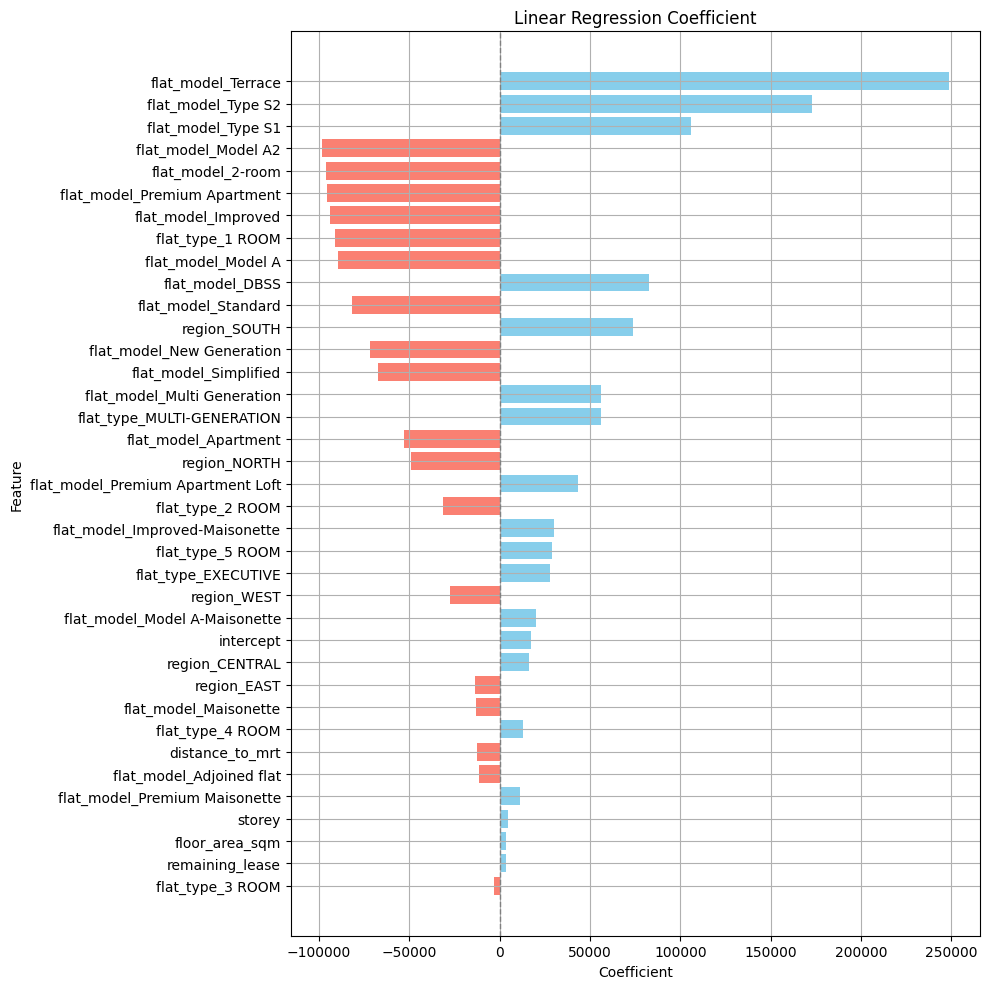

In [74]:
# Create visualization
colors = ['skyblue' if coef >=0 else 'salmon' for coef in coef_df_lr['coefficient']]
plt.figure(figsize=(10, 10))
plt.barh(coef_df_lr['feature'], coef_df_lr['coefficient'], color=colors)
plt.title('Linear Regression Coefficient')
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.axvline(x=0, color='gray', linestyle='--', linewidth=1)
plt.gca().invert_yaxis()
plt.grid()
plt.tight_layout()
plt.show()

**Observation:** <br>
- The coefficient shows how much influence a feature has on the target.
- Positive and negative signs indicate the direction of influence.
  - A positive coefficient indicates that an **increase** in the feature leads to a **higher** resale price.
  - A negative coefficient indicates that an **increase** in the feature leads to a **lower** resale price. <br>

**Example of Interpretation:** <br>
Feature `flat_model_Terrace` that has a coefficient of ~248528 means that flat with Terrace model, increase the resale price by ~248528, assuming all other features remain constant. <br>

**Interpretation:** <br>
This model has a strange interpretation. Let's compare it with another model to prove it.

### Ridge Regression
*Interpretable Model*

In [75]:
# Create dataframe to compile feature and coefficient correlation
data = X_train
model = best_ridge

coef_df_ridge = pd.DataFrame({
    'feature': ['intercept'] + list(data.columns),
    'coefficient': [model.intercept_] + list(model.coef_)
})

# Sort by absolute value of coefficients for better visualization
coef_df_ridge['abs_coefficient'] = coef_df_ridge['coefficient'].abs()
coef_df_ridge = coef_df_ridge.sort_values(by='abs_coefficient', ascending=False)
coef_df_ridge = coef_df_ridge.drop('abs_coefficient', axis=1)

coef_df_ridge

,feature,coefficient
0,intercept,438309.126797
1,floor_area_sqm,85982.298980
3,distance_to_mrt,-51685.189962
2,remaining_lease,42619.692754
36,storey,25508.355579
34,region_SOUTH,22132.295142
14,flat_model_DBSS,18423.953929
33,region_NORTH,-14872.274549
17,flat_model_Maisonette,10924.482635
31,region_CENTRAL,9682.933836


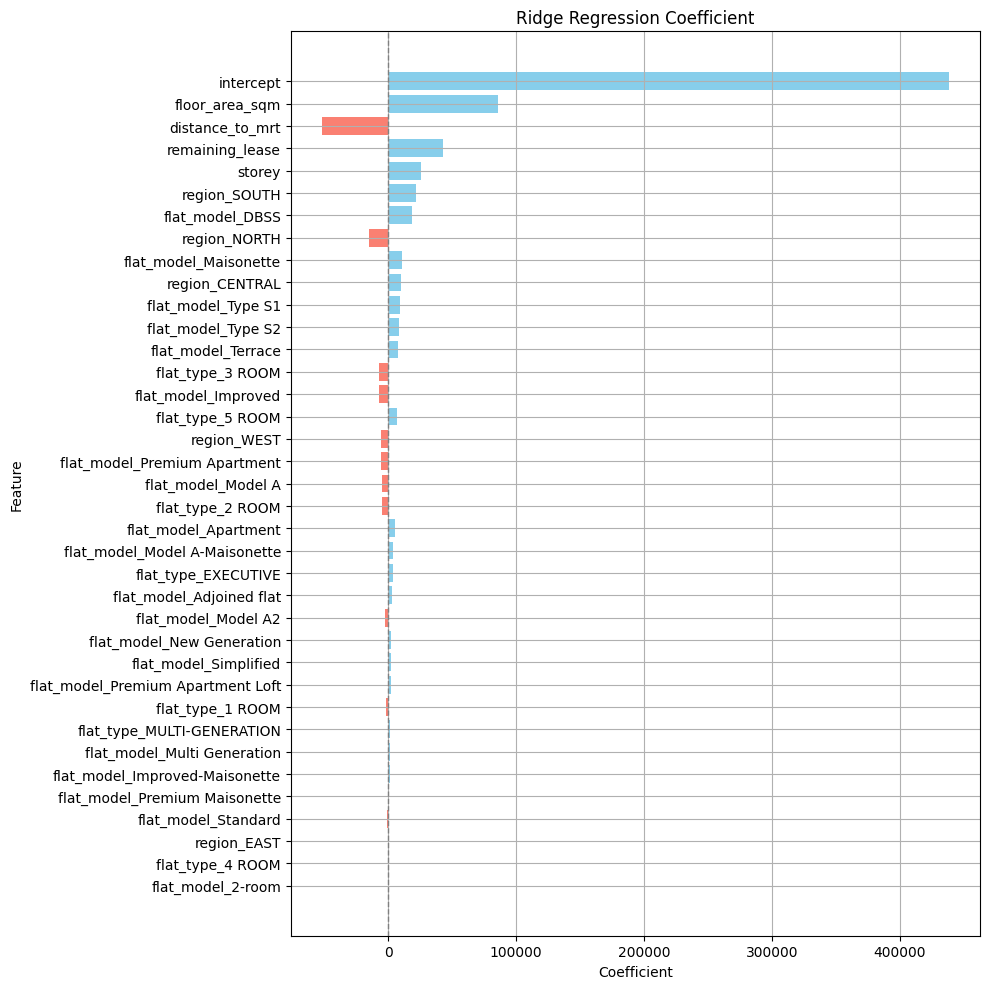

In [76]:
# Create visualization
colors = ['skyblue' if coef >=0 else 'salmon' for coef in coef_df_ridge['coefficient']]
plt.figure(figsize=(10, 10))
plt.barh(coef_df_ridge['feature'], coef_df_ridge['coefficient'], color=colors)
plt.title('Ridge Regression Coefficient')
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.axvline(x=0, color='gray', linestyle='--', linewidth=1)
plt.gca().invert_yaxis()
plt.grid()
plt.tight_layout()
plt.show()

**Observation:** <br>
- The coefficient shows how much influence a feature has on the target.
- Positive and negative signs indicate the direction of influence.
  - A positive coefficient indicates that an **increase** in the feature leads to a **higher** resale price.
  - A negative coefficient indicates that an **increase** in the feature leads to a **lower** resale price. <br>

**Example of Interpretation:** <br>
Feature `floor_area_sqm` that has a coefficient of ~85982 means that for every 1 additional square meter floor area, the odds of resale price increase by ~85982, assuming all other features remain constant.

**Interpretation:** <br>
- `floor_area_sqm`: Bigger floor area → Higher resale price.
- `distance_to_mrt`: Flats near MRT stations → Higher resale price.
- `remaining_lease`: Longer remaining_lease → Higher resale price.
- `storey`: Higher floors → Higher resale price.
- `region`: Flats in the south and central regions tend to be more expensive than those in the north and west regions.
- `flat_model`: Flats such as DBSS, Maisonette, Type S1, Type S2, and Terrace generally have higher resale prices.
- `flat_type`: Flats with more rooms generally have higher resale prices.

### Random Forest Regression
*Non-Interpretable Model -> Use Model Agnostic Method*

In [77]:
# Initiate explainer for Random Forest model
rf_exp = dx.Explainer(rf, X_train, y_train, label='Random Forest Interpretation')

Preparation of a new explainer is initiated

  -> data              : 93811 rows 36 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 93811 values
  -> model_class       : sklearn.ensemble._forest.RandomForestRegressor (default)
  -> label             : Random Forest Interpretation
  -> predict function  : <function yhat_default at 0x7a09abff22a0> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 1.67e+05, mean = 4.38e+05, max = 1.23e+06
  -> model type        : regression will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -1.14e+05, mean = 1.29e+02, max = 1.55e+05
  -> model_info        : package sklearn

A new explainer has been created!


#### **Permutation Feature Importance**

In [78]:
# Visualize permutation feature importance for Random Forest Model
rf_exp.model_parts().plot()

**Observation:** <br>
- floor_area_sqm (+146747.447) → This feature has the greatest influence on the predicted value. When this feature is removed (shuffled), the model's error increases by 146,747.447.
- distance_to_mrt (+119994.474) → This feature is also crucial, increasing error by 119,994.474 when removed.
- remaining_lease (+71019.125) → Still important but less than the top two.
- and so on ...

**Summary:** <br>
- Higher values = The feature has a strong impact on model predictions.
- Lower values = The feature has less influence.
- Later we will check the Feature Importance of XGBoost model to validate this interpretation.

#### **Partial Dependence Plot (PDP)**

In [79]:
# Create partial dependence plot of Random Forest model
rf_exp.model_profile().plot()

Calculating ceteris paribus:   0%|          | 0/36 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/dalex/predict_explanations/_ceteris_paribus/utils.py:100: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 31.    33.49  35.98 ... 275.02 277.51 280.  ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

Calculating ceteris paribus:   3%|▎         | 1/36 [00:01<00:51,  1.48s/it]/usr/local/lib/python3.11/dist-packages/dalex/predict_explanations/_ceteris_paribus/utils.py:100: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[45.   45.52 46.04 ... 95.96 96.48 97.  ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

Calculating ceteris paribus:   8%|▊         | 3/36 [00:03<00:35,  1.07s/it]/usr/local/lib/python3.11/dist-packages/dalex/predict_explanations/_ceteris_parib

**Observation:** <br>
**Observation:** <br>
- `floor_area_sqm`:
  - The graph exhibits a strong positive trend: the larger the floor area, the higher the resale price.
  - The price increase is quite significant up to around 150 sqm, then it starts to plateau after reaching approximately 200-250 sqm.
  - This indicates that floor area is a major contributing factor to the resale price.

- `remaining_lease`:
  - The graph also shows a positive trend, though more gradual compared to floor area.
  - The longer the remaining lease, the higher the resale price, with a more noticeable price increase as the lease approaches 90 years.
  - However, there is a sharper increase at the end of the range, possibly indicating that apartments with very long leases are significantly more valuable.

- `distance_to_MRT`:
  - The trend shows a negative correlation between distance to the MRT station and resale price.
  - Closer proximity to the MRT (0-5 km) is associated with higher resale prices, peaking around 1-2 km.
  - Beyond 5 km, prices gradually decrease, with some fluctuations around 7-10 km.
  - After 10 km, the trend stabilizes at a lower resale price level, suggesting that apartments far from MRT stations tend to have consistently lower prices.

### XGBoost Regression
*Non-Interpretable Model -> Use Model Agnostic Method*

In [80]:
# Initiate explainer for XGBoost model
xgb_exp = dx.Explainer(xgb, X_train, y_train, label='XGBoost Interpretation')

Preparation of a new explainer is initiated

  -> data              : 93811 rows 36 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 93811 values
  -> model_class       : xgboost.sklearn.XGBRegressor (default)
  -> label             : XGBoost Interpretation
  -> predict function  : <function yhat_default at 0x7a09abff22a0> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 1.63e+05, mean = 4.38e+05, max = 1.23e+06
  -> model type        : regression will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -2.52e+05, mean = 1.35, max = 2.47e+05
  -> model_info        : package xgboost

A new explainer has been created!


#### **Permutation Feature Importance**

In [81]:
# Visualize permutation feature importance for XGBoost Model
xgb_exp.model_parts().plot()

**Observation:** <br>
- floor_area_sqm (+107716.823) → This feature has the greatest influence on the predicted value. When this feature is removed (shuffled), the model's error increases by 107,716.823.
- distance_to_mrt (+88193.747) → This feature is also crucial, increasing error by 88,193.747 when removed.
- remaining_lease (+43015.891) → Still important but less than the top two.
- and so on ...

**Summary:** <br>
- The order of influence of the first 3 features between Random Forest and XGBoost is the same (floor_area_sqm, distance_to_mrt, remain_lease). The rest have different orders.

#### **Partial Dependence Plot (PDP)**

In [82]:
# Create partial dependence plot of XGBoost model
xgb_exp.model_profile().plot()

Calculating ceteris paribus:   0%|          | 0/36 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/dalex/predict_explanations/_ceteris_paribus/utils.py:100: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 31.    33.49  35.98 ... 275.02 277.51 280.  ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

/usr/local/lib/python3.11/dist-packages/dalex/predict_explanations/_ceteris_paribus/utils.py:100: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[45.   45.52 46.04 ... 95.96 96.48 97.  ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

Calculating ceteris paribus:   6%|▌         | 2/36 [00:00<00:03, 10.20it/s]/usr/local/lib/python3.11/dist-packages/dalex/predict_explanations/_ceteris_paribus/utils.py:100: FutureWarning:

Setting an item of incompatible dtype is d

**Observation:** <br>
- `floor_area_sqm`:
  - The graph exhibits a strong positive trend: the larger the floor area, the higher the resale price.
  - The price increase is quite significant up to around 150 sqm, then it starts to plateau after reaching approximately 200-250 sqm.
  - This indicates that floor area is a major contributing factor to the resale price.

- `remaining_lease`:
  - The graph also shows a positive trend, though more gradual compared to floor area.
  - The longer the remaining lease, the higher the resale price, with a more noticeable price increase as the lease approaches 90 years.
  - However, there is a sharper increase at the end of the range, possibly indicating that apartments with very long leases are significantly more valuable.

- `distance_to_MRT`:
  - The trend shows a negative correlation between distance to the MRT station and resale price.
  - Closer proximity to the MRT (0-5 km) is associated with higher resale prices, peaking around 1-2 km.
  - Beyond 5 km, prices gradually decrease, with some fluctuations around 7-10 km.
  - After 10 km, the trend stabilizes at a lower resale price level, suggesting that apartments far from MRT stations tend to have consistently lower prices.

## Model Evaluation
Evaluation using:
- Residual Plot
- Regression Metrics (MAE, MAPE, RMSE, R2 score)

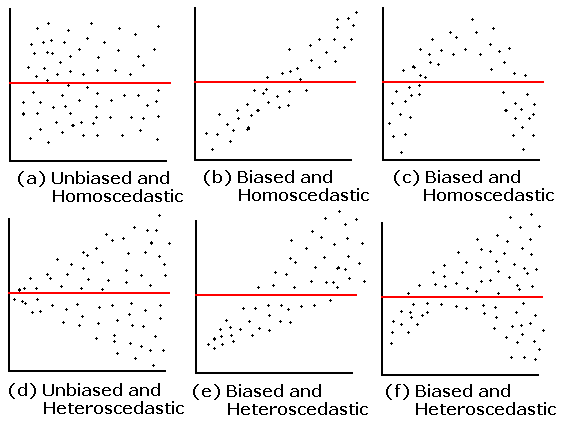

In [83]:
# GitHub raw image URL
url = "https://raw.githubusercontent.com/valdo28/singaporehdb/main/images/resid-plots.gif"

# Load and display the image
response = requests.get(url)
img = Image.open(BytesIO(response.content))
display(img)

### Linear Regression (Baseline Model)

#### Training Set

In [84]:
# Create prediction
y_predict_train_lr = lr.predict(X_train)

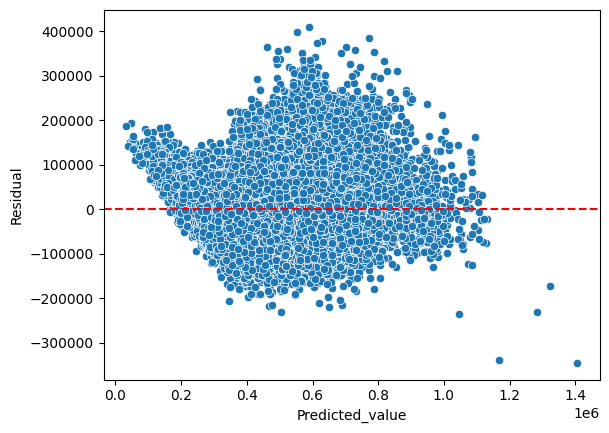

In [85]:
# Calculate Residuals
residual_lr = y_train - y_predict_train_lr

# Create DataFrame
df_res_lr = pd.DataFrame({
    'Predicted_value': y_predict_train_lr,
    'Residual': residual_lr
})

# Check Residual Plot
sns.scatterplot(data=df_res_lr, x='Predicted_value', y='Residual')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

**Observation:** <br>
Unbiased and Homoscedastic -> Good!

In [86]:
# Evaluation using Regression Metrics
lr_mae_train = mean_absolute_error(y_train, y_predict_train_lr)
print('MAE for train data is {}'.format(lr_mae_train))

lr_mape_train = mean_absolute_percentage_error(y_train, y_predict_train_lr)
print('MAPE for train data is {}'.format(lr_mape_train))

lr_rmse_train = np.sqrt(mean_squared_error(y_train, y_predict_train_lr))
print('RMSE for train data is {}'.format(lr_rmse_train))

lr_r2_train = r2_score(y_train, y_predict_train_lr)
print('R2 for train data is {}'.format(lr_r2_train))

MAE for train data is 48163.48548765255
MAPE for train data is 0.11508908716422356
RMSE for train data is 61989.76253628097
R2 for train data is 0.8249217669431607


#### Test Set

In [87]:
# Create prediction
y_predict_test_lr = lr.predict(X_test)

In [88]:
# Evaluation using Regression Metrics
lr_mae_test = mean_absolute_error(y_test, y_predict_test_lr)
print('MAE for test data is {}'.format(lr_mae_test))

lr_mape_test = mean_absolute_percentage_error(y_test, y_predict_test_lr)
print('MAPE for test data is {}'.format(lr_mape_test))

lr_rmse_test = np.sqrt(mean_squared_error(y_test, y_predict_test_lr))
print('RMSE for test data is {}'.format(lr_rmse_test))

lr_r2_test = r2_score(y_test, y_predict_test_lr)
print('R2 for test data is {}'.format(lr_r2_test))

MAE for test data is 48465.64648468422
MAPE for test data is 0.11537182882722047
RMSE for test data is 62105.393941518574
R2 for test data is 0.8245898531374989


### Ridge Regression

#### Training Set

In [89]:
# Create prediction
y_predict_train_ridge = best_ridge.predict(X_train_scaled)

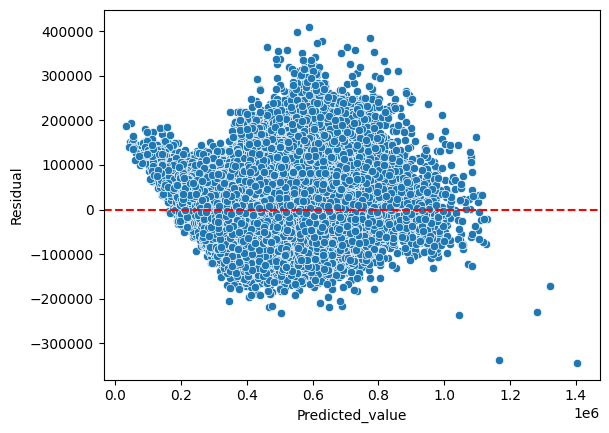

In [90]:
# Calculate Residuals
residual_ridge = y_train - y_predict_train_ridge

# Create DataFrame
df_res_ridge = pd.DataFrame({
    'Predicted_value': y_predict_train_ridge,
    'Residual': residual_ridge
})

# Check Residual Plot
sns.scatterplot(data=df_res_ridge, x='Predicted_value', y='Residual')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

**Observation:** <br>
Unbiased and Homoscedastic -> Good!

In [91]:
# Evaluation using Regression Metrics
ridge_mae_train = mean_absolute_error(y_train, y_predict_train_ridge)
print('MAE for train data is {}'.format(ridge_mae_train))

ridge_mape_train = mean_absolute_percentage_error(y_train, y_predict_train_ridge)
print('MAPE for train data is {}'.format(ridge_mape_train))

ridge_rmse_train = np.sqrt(mean_squared_error(y_train, y_predict_train_ridge))
print('RMSE for train data is {}'.format(ridge_rmse_train))

ridge_r2_train = r2_score(y_train, y_predict_train_ridge)
print('R2 for train data is {}'.format(ridge_r2_train))

MAE for train data is 48162.10467414593
MAPE for train data is 0.11508283642279031
RMSE for train data is 61989.77499137452
R2 for train data is 0.8249216965890924


#### Test Set

In [92]:
# Create prediction
y_predict_test_ridge = best_ridge.predict(X_test_scaled)

In [93]:
# Evaluation using Regression Metrics
ridge_mae_test = mean_absolute_error(y_test, y_predict_test_ridge)
print('MAE for test data is {}'.format(ridge_mae_test))

ridge_mape_test = mean_absolute_percentage_error(y_test, y_predict_test_ridge)
print('MAPE for test data is {}'.format(ridge_mape_test))

ridge_rmse_test = np.sqrt(mean_squared_error(y_test, y_predict_test_ridge))
print('RMSE for test data is {}'.format(ridge_rmse_test))

ridge_r2_test = r2_score(y_test, y_predict_test_ridge)
print('R2 for test data is {}'.format(ridge_r2_test))

MAE for test data is 48464.11872456196
MAPE for test data is 0.11536486602160606
RMSE for test data is 62105.35746735337
R2 for test data is 0.8245900591723178


### Random Forest Regression

#### Train Set

In [94]:
# Create prediction
y_predict_train_rf = rf.predict(X_train)

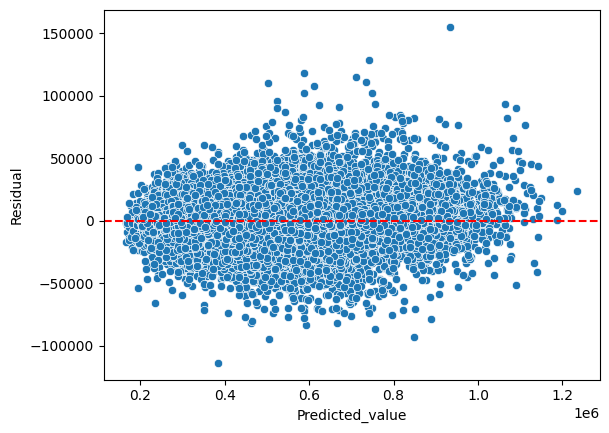

In [95]:
# Calculate Residuals
residual_rf = y_train - y_predict_train_rf

# Create DataFrame
df_res_rf = pd.DataFrame({
    'Predicted_value': y_predict_train_rf,
    'Residual': residual_rf
})

# Check Residual Plot
sns.scatterplot(data=df_res_rf, x='Predicted_value', y='Residual')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

**Observation:** <br>
Unbiased and Homoscedastic -> Good!

In [96]:
# Evaluation using Regression Metrics
rf_mae_train = mean_absolute_error(y_train, y_predict_train_rf)
print('MAE for train data is {}'.format(rf_mae_train))

rf_mape_train = mean_absolute_percentage_error(y_train, y_predict_train_rf)
print('MAPE for train data is {}'.format(rf_mape_train))

rf_rmse_train = np.sqrt(mean_squared_error(y_train, y_predict_train_rf))
print('RMSE for train data is {}'.format(rf_rmse_train))

rf_r2_train = r2_score(y_train, y_predict_train_rf)
print('R2 for train data is {}'.format(rf_r2_train))

MAE for train data is 8184.6761525846305
MAPE for train data is 0.01924974803985922
RMSE for train data is 11662.054604967525
R2 for train data is 0.993803558546346


#### Test Set

In [97]:
# Create prediction
y_predict_test_rf = rf.predict(X_test)

In [98]:
# Evaluation using Regression Metrics
rf_mae_test = mean_absolute_error(y_test, y_predict_test_rf)
print('MAE for test data is {}'.format(rf_mae_test))

rf_mape_test = mean_absolute_percentage_error(y_test, y_predict_test_rf)
print('MAPE for test data is {}'.format(rf_mape_test))

rf_rmse_test = np.sqrt(mean_squared_error(y_test, y_predict_test_rf))
print('RMSE for test data is {}'.format(rf_rmse_test))

rf_r2_test = r2_score(y_test, y_predict_test_rf)
print('R2 for test data is {}'.format(rf_r2_test))

MAE for test data is 20259.04572212022
MAPE for test data is 0.04698889278116965
RMSE for test data is 28675.497471676877
R2 for test data is 0.9626046164309329


### XGBoost Regression

#### Train Set

In [99]:
# Create prediction
y_predict_train_xgb = xgb.predict(X_train)

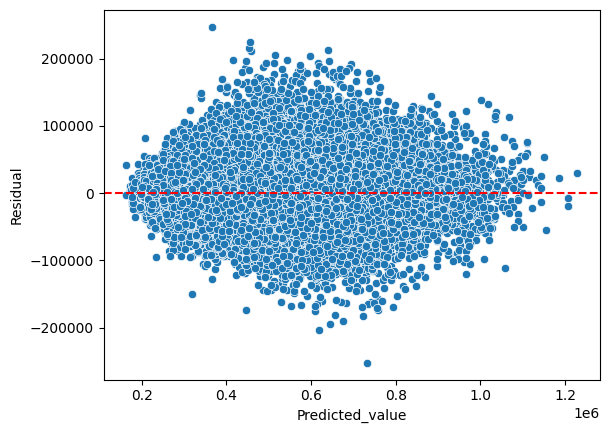

In [100]:
# Calculate Residuals
residual_xgb = y_train - y_predict_train_xgb

# Create DataFrame
df_res_xgb = pd.DataFrame({
    'Predicted_value': y_predict_train_xgb,
    'Residual': residual_xgb
})

# Check Residual Plot
sns.scatterplot(data=df_res_xgb, x='Predicted_value', y='Residual')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

**Observation:** <br>
Unbiased and Homoscedastic -> Good!

In [101]:
# Evaluation using Regression Metrics
xgb_mae_train = mean_absolute_error(y_train, y_predict_train_xgb)
print('MAE for train data is {}'.format(xgb_mae_train))

xgb_mape_train = mean_absolute_percentage_error(y_train, y_predict_train_xgb)
print('MAPE for train data is {}'.format(xgb_mape_train))

xgb_rmse_train = np.sqrt(mean_squared_error(y_train, y_predict_train_xgb))
print('RMSE for train data is {}'.format(xgb_rmse_train))

xgb_r2_train = r2_score(y_train, y_predict_train_xgb)
print('R2 for train data is {}'.format(xgb_r2_train))

MAE for train data is 23888.081087239236
MAPE for train data is 0.055892216536161804
RMSE for train data is 32402.22596350788
R2 for train data is 0.952165424823761


#### Test Set

In [102]:
# Create prediction
y_predict_test_xgb = xgb.predict(X_test)

In [103]:
# Evaluation using Regression Metrics
xgb_mae_test = mean_absolute_error(y_test, y_predict_test_xgb)
print('MAE for test data is {}'.format(xgb_mae_test))

xgb_mape_test = mean_absolute_percentage_error(y_test, y_predict_test_xgb)
print('MAPE for test data is {}'.format(xgb_mape_test))

xgb_rmse_test = np.sqrt(mean_squared_error(y_test, y_predict_test_xgb))
print('RMSE for test data is {}'.format(xgb_rmse_test))

xgb_r2_test = r2_score(y_test, y_predict_test_xgb)
print('R2 for test data is {}'.format(xgb_r2_test))

MAE for test data is 25337.927939655907
MAPE for test data is 0.058678594553223475
RMSE for test data is 34601.084825121965
R2 for test data is 0.9455528259277344


In [104]:
summary_df = pd.DataFrame({
    'Model': ['Linear Regression', 'Ridge Regression', 'Random Forest', 'XGBoost'],
    'MAE_train': [lr_mae_train, ridge_mae_train, rf_mae_train, xgb_mae_train],
    'MAE_test': [lr_mae_test, ridge_mae_test, rf_mae_test, xgb_mae_test],
    'MAPE_train': [lr_mape_train, ridge_mape_train, rf_mape_train, xgb_mape_train],
    'MAPE_test': [lr_mape_test, ridge_mape_test, rf_mape_test, xgb_mape_test],
    'RMSE_train': [lr_rmse_train, ridge_rmse_train, rf_rmse_train, xgb_rmse_train],
    'RMSE_test': [lr_rmse_test, ridge_rmse_test, rf_rmse_test, xgb_rmse_test],
    'R2_train': [lr_r2_train, ridge_r2_train, rf_r2_train, xgb_r2_train],
    'R2_test': [lr_r2_test, ridge_r2_test, rf_r2_test, xgb_r2_test]})

summary_df.set_index('Model').T

Model,Linear Regression,Ridge Regression,Random Forest,XGBoost
MAE_train,48163.485488,48162.104674,8184.676153,23888.081087
MAE_test,48465.646485,48464.118725,20259.045722,25337.927940
MAPE_train,0.115089,0.115083,0.019250,0.055892
MAPE_test,0.115372,0.115365,0.046989,0.058679
RMSE_train,61989.762536,61989.774991,11662.054605,32402.225964
RMSE_test,62105.393942,62105.357467,28675.497472,34601.084825
R2_train,0.824922,0.824922,0.993804,0.952165
R2_test,0.824590,0.824590,0.962605,0.945553


**Observation:** <br>
- Best model is Random Forest Regressor with 96% of R2 score. High R2 score means that the model can captures trends / explains variance very well.
- All model are not overfitting or underfitting. Because R2 score of train data and test data are likely same, also the lowest R2 score of the models are above 80%.
- Mean Absolute Error (MAE): The average absolute error between actual and predicted values is ~19,977 SGD. **Lower MAE is better.** Since resale prices are in the range of 140,000 SGD to 1,258,000 SGD, an error of ~19,977 is relatively small, indicating good model performance.
- Mean Absolute Percentage Error (MAPE): Measures relative error as a percentage of actual values. <br>
Interpretation:
https://www.researchgate.net/figure/MAPE-Value-for-Prediction-Evaluation-36_tbl2_318055885
  - MAPE < 10% → High Accuracy
  - MAPE 10-20% → Good Accuracy
  - MAPE 20-50% → Reasonable Accuracy
  - MAPE > 50% → Low Accuracy
  - Since the MAPE of the model's prediction are 4.31% it means that, only 4.31% off from actual resale prices. So, we can say that this model has high accuracy.
- Root Mean Squared Error (RMSE): Measures the square root of the average squared error. <br>
Interpretation:
  - RMSE is higher than MAE because it penalizes large errors more.
  - Since RMSE is much smaller than the average resale price (~438,533), the model performs well.

## Summary and Recommendation

**Summary:** <br>

**Model Interpretation:** <br>
- Linear Regression (Baseline model) has a strange interpretation.
- Other models, such as Ridge Regression, Random Forest, and XGBoost, have similarity and sensible interpretations.

**Model Evaluation:** <br>
- Random Forest is the best model

**Recommendations:**

**For Buyers:** <br>
Buyers should consider the following factors:
- `floor_area_sqm`: Floor area is the most significant factor influencing resale price. If a buyer wants a more affordable flat, they should look for one with a smaller floor area.
- `distance_to_mrt`: Flats near MRT stations tend to have higher resale prices. If a buyer is seeking a cheaper flat, they should look for one that is farther from the MRT. However, this will likely result in longer commute times.
- `remaining_lease`: If a buyer wants a more affordable flat, they should look for one with a shorter remaining lease, but not one that is too short to affect future convenience.
- `storey`: Higher floors generally command higher resale prices but may offer more comfort due to fewer visitors on upper levels.
- `region`: Flats in the south and central regions tend to be more expensive than those in the north and west regions.
- `flat_model`: Flats such as DBSS, Maisonette, Type S1, Type S2, and Terrace generally have higher resale prices.
- `flat_type`: Flats with more rooms generally have higher resale prices.

**For the Government:**
- The government should consider building more transportation options (such as MRT lines), shopping centers, schools, and other public facilities to help increase the resale prices of flats.